In [1]:
"""
GPU-Accelerated Boolean Jet Space Analysis for ECA Pattern Detection
=====================================================================

This experiment detects higher-order patterns in Elementary Cellular Automata
using Boolean jet spaces computed on GPU via CuPy.
"""

import cupy as cp
import numpy as np
from typing import Dict, List, Tuple, Set
from dataclasses import dataclass
import time
from collections import defaultdict

@dataclass
class JetSpaceConfig:
    """Configuration for jet space analysis"""
    n: int  # System size (number of cells)
    k_max: int  # Maximum jet order
    rule: int  # Wolfram rule number
    samples: int  # Number of random initial conditions (0 = exhaustive/all 2^n)

    @property
    def jet_space_bits(self):
        """Total bits in maximum jet space"""
        return (self.k_max + 1) * self.n

    @property
    def is_exhaustive(self):
        """Check if running exhaustive analysis"""
        return self.samples == 0

    @property
    def total_ics(self):
        """Total number of initial conditions to test"""
        return 2**self.n if self.is_exhaustive else self.samples

# ============================================================================
# Core Jet Space Operations (GPU-Accelerated)
# ============================================================================

class BooleanJetSpace:
    """GPU-accelerated Boolean Jet Space computer for ECAs"""

    def __init__(self, rule: int, n: int):
        self.rule = rule
        self.n = n
        self.rule_bits = cp.array([(rule >> i) & 1 for i in range(8)], dtype=cp.uint8)

    def eca_step(self, x: cp.ndarray) -> cp.ndarray:
        """Single ECA update step - fully vectorized"""
        # Extract neighborhoods using roll operations (more efficient than tensor)
        left = cp.roll(x, 1)
        center = x
        right = cp.roll(x, -1)

        # Compute pattern indices (0-7) for each cell
        patterns = (left << 2) | (center << 1) | right

        # Apply rule via lookup table
        x_next = self.rule_bits[patterns]

        return x_next

    def compute_jet(self, x0: cp.ndarray, k: int) -> cp.ndarray:
        """
        Compute k-order Boolean jet space
        Returns: J^k(x) in shape (k+1, n) where row j = d^j f(x)
        """
        jet = cp.zeros((k+1, self.n), dtype=cp.uint8)
        jet[0] = x0

        x_current = x0.copy()
        for j in range(1, k+1):
            x_current = self.eca_step(x_current)
            jet[j] = x0 ^ x_current  # d^j f(x) = x^(0) ⊕ x^(j)

        return jet

# ============================================================================
# Pattern Detection Algorithms
# ============================================================================

class PatternDetector:
    """Detect cycles and invariants in jet space"""

    def __init__(self, jet_computer: BooleanJetSpace):
        self.jc = jet_computer
        self.n = jet_computer.n

    def detect_cycle_from_jet(self, jet: cp.ndarray) -> Tuple[int, int]:
        """
        Detect cycle period and transient length from jet matrix

        Returns: (period, transient_length)
            period: 0 = no cycle found
                   1 = fixed point (x^(1) = x^(0))
                   2+ = periodic cycle of that length
            transient_length: steps before entering cycle (0 for now)
        """
        k_max = jet.shape[0] - 1

        # jet[j] = x^(0) ⊕ x^(j), so jet[j] = 0 means x^(j) = x^(0)
        for p in range(1, k_max + 1):
            if cp.all(jet[p] == 0):
                # Found return to initial state after p steps
                # p=1 means fixed point, p=2 means period-2, etc.
                return p, 0

        # No cycle detected within k_max steps
        return 0, 0

    def detect_general_cycle(self, x0: cp.ndarray, max_steps: int = None) -> Tuple[int, int]:
        """
        Detect cycles including those with transients (more general than jet-based)
        Uses Floyd's cycle detection algorithm

        Returns: (period, transient_length)
        """
        if max_steps is None:
            max_steps = min(2**self.n, 10000)  # Bounded by state space size

        # Keep track of visited states
        visited = {}
        x = x0.copy()

        for t in range(max_steps):
            # Convert state to hashable key
            state_key = tuple(x.get().tolist())

            if state_key in visited:
                # Found a cycle!
                transient_length = visited[state_key]
                period = t - transient_length
                return period, transient_length

            visited[state_key] = t
            x = self.jc.eca_step(x)

        # No cycle found within max_steps
        return 0, 0

    def find_invariant_subspace(self, jet: cp.ndarray) -> Dict:
        """
        Identify invariant subspaces in jet representation
        """
        # Compute Hamming weights for each derivative order
        weights = cp.sum(jet, axis=1)

        # Find when weights stabilize (invariant reached)
        stable_idx = -1
        for i in range(1, len(weights)):
            if i > 2 and weights[i] == weights[i-1] == weights[i-2]:
                stable_idx = i - 2
                break

        # Identify frozen bits (never change across all derivatives)
        frozen_mask = cp.all(jet[1:] == 0, axis=0)
        active_mask = ~frozen_mask

        return {
            'weights': weights.get(),  # Transfer to CPU for analysis
            'stable_index': stable_idx,
            'frozen_bits': cp.sum(frozen_mask).item(),
            'active_bits': cp.sum(active_mask).item(),
            'activity_ratio': cp.sum(active_mask).item() / self.n
        }

    def compute_jet_entropy(self, jet: cp.ndarray) -> float:
        """
        Compute entropy of jet space configuration
        Measures complexity of derivative patterns
        """
        # Flatten jet to binary string and compute pattern frequencies
        flat = jet.flatten()
        ones = cp.sum(flat).item()
        zeros = flat.size - ones

        if ones == 0 or zeros == 0:
            return 0.0

        p1 = ones / flat.size
        p0 = zeros / flat.size

        entropy = -(p1 * np.log2(p1) + p0 * np.log2(p0))
        return entropy

# ============================================================================
# Experiment Runner
# ============================================================================

class JetSpaceExperiment:
    """Main experiment controller"""

    def __init__(self, config: JetSpaceConfig):
        self.config = config
        self.jet_computer = BooleanJetSpace(config.rule, config.n)
        self.detector = PatternDetector(self.jet_computer)
        self.results = defaultdict(list)

    def run_single_ic(self, x0: cp.ndarray) -> Dict:
        """Run analysis for single initial condition"""
        # Compute jet space up to k_max
        jet = self.jet_computer.compute_jet(x0, self.config.k_max)

        # Detect patterns
        period, transient = self.detector.detect_cycle_from_jet(jet)
        invariants = self.detector.find_invariant_subspace(jet)
        entropy = self.detector.compute_jet_entropy(jet)

        # Advanced: Check for higher-order periodicities
        # (patterns in derivative space not visible in state space)
        derivative_periods = self._detect_derivative_periods(jet)

        return {
            'period': period,
            'transient': transient,
            'invariants': invariants,
            'entropy': entropy,
            'derivative_periods': derivative_periods,
            'jet_matrix': jet
        }

    def _detect_derivative_periods(self, jet: cp.ndarray) -> List[int]:
        """
        Detect periodicities in individual derivative orders
        These reveal hidden oscillations not visible in base state
        """
        periods = []

        for d_order in range(1, min(5, jet.shape[0])):
            # Check if d^i f repeats with some period
            row = jet[d_order]

            for p in range(1, min(20, self.config.k_max // 2)):
                if d_order + p < jet.shape[0]:
                    if cp.array_equal(row, jet[d_order + p]):
                        periods.append(p)
                        break

        return periods

    def run_full_experiment(self) -> Dict:
        """Run complete experiment over multiple initial conditions"""
        print(f"Starting Jet Space Experiment for Rule {self.config.rule}")
        print(f"System size: {self.config.n}, Max jet order: {self.config.k_max}")

        start_time = time.time()

        # Generate initial conditions based on samples parameter
        if self.config.samples == 0:
            # Exhaustive: All 2^n possible initial conditions
            print(f"Running EXHAUSTIVE analysis: all 2^{self.config.n} initial conditions")
            if self.config.n > 20:
                print(f"WARNING: This will create {2**self.config.n} states - may run out of memory!")

            # Generate all binary strings of length n
            total_ics = 2**self.config.n
            initial_conditions = self._generate_all_binary_states()
            print(f"Generated {total_ics} initial conditions")
        else:
            # Random sampling
            print(f"Samples: {self.config.samples} (random)")
            cp.random.seed(42)
            initial_conditions = cp.random.randint(0, 2,
                                                  (self.config.samples, self.config.n),
                                                  dtype=cp.uint8)
            total_ics = self.config.samples

        print("-" * 60)

        # Run analysis for each IC
        for i, x0 in enumerate(initial_conditions):
            result = self.run_single_ic(x0)

            # Aggregate results
            self.results['periods'].append(result['period'])
            self.results['entropies'].append(result['entropy'])
            self.results['invariants'].append(result['invariants'])
            self.results['derivative_periods'].extend(result['derivative_periods'])

            if i % max(1, total_ics // 10) == 0:
                print(f"Processed {i}/{total_ics} samples ({100*i/total_ics:.1f}%)...")

        # Compute statistics
        stats = self._compute_statistics()

        elapsed = time.time() - start_time
        print(f"\nExperiment completed in {elapsed:.2f} seconds")
        print(f"Throughput: {total_ics/elapsed:.2f} ICs/second")

        return stats

    def _generate_all_binary_states(self) -> cp.ndarray:
        """
        Generate all 2^n possible binary states efficiently
        Uses bit manipulation to create all possible n-bit patterns
        """
        n = self.config.n
        num_states = 2**n

        if n <= 16:
            # For small n, generate on GPU directly
            states = cp.zeros((num_states, n), dtype=cp.uint8)
            for i in range(num_states):
                for j in range(n):
                    states[i, j] = (i >> j) & 1
            return states
        else:
            # For larger n, generate in batches to manage memory
            batch_size = min(65536, num_states)  # Process in chunks
            states_list = []

            for batch_start in range(0, num_states, batch_size):
                batch_end = min(batch_start + batch_size, num_states)
                batch_states = cp.zeros((batch_end - batch_start, n), dtype=cp.uint8)

                for i in range(batch_end - batch_start):
                    state_idx = batch_start + i
                    for j in range(n):
                        batch_states[i, j] = (state_idx >> j) & 1

                states_list.append(batch_states)

            # Return as a generator-like iterator to save memory
            return cp.vstack(states_list) if len(states_list) > 1 else states_list[0]

    def _compute_statistics(self) -> Dict:
        """Aggregate and analyze results"""
        periods = np.array(self.results['periods'])
        entropies = np.array(self.results['entropies'])

        # Period distribution
        unique_periods, period_counts = np.unique(periods, return_counts=True)

        # Classify by period type
        no_cycle_count = np.sum(periods == 0)
        fixed_point_count = np.sum(periods == 1)
        periodic_count = np.sum(periods > 1)

        # Derivative period analysis
        deriv_periods = self.results['derivative_periods']
        if deriv_periods:
            unique_deriv_periods, deriv_counts = np.unique(deriv_periods,
                                                          return_counts=True)
        else:
            unique_deriv_periods, deriv_counts = [], []

        # Activity analysis
        avg_frozen = np.mean([inv['frozen_bits']
                              for inv in self.results['invariants']])
        avg_activity = np.mean([inv['activity_ratio']
                                for inv in self.results['invariants']])

        stats = {
            'rule': self.config.rule,
            'period_distribution': dict(zip(unique_periods.tolist(),
                                          period_counts.tolist())),
            'period_classification': {
                'no_cycle_found': int(no_cycle_count),
                'fixed_points': int(fixed_point_count),
                'periodic_cycles': int(periodic_count)
            },
            'mean_entropy': float(np.mean(entropies)),
            'std_entropy': float(np.std(entropies)),
            'derivative_periods': dict(zip(unique_deriv_periods.tolist() if len(unique_deriv_periods) > 0 else [],
                                          deriv_counts.tolist() if len(deriv_counts) > 0 else [])),
            'avg_frozen_bits': float(avg_frozen),
            'avg_activity_ratio': float(avg_activity),
            'max_period_detected': int(np.max(periods)) if len(periods) > 0 else 0
        }

        # Add interpretation
        if self.config.is_exhaustive:
            total = len(periods)
            stats['interpretation'] = {
                'fixed_point_ratio': fixed_point_count / total if total > 0 else 0,
                'periodic_ratio': periodic_count / total if total > 0 else 0,
                'undetected_ratio': no_cycle_count / total if total > 0 else 0
            }

        return stats

# ============================================================================
# Main Experimental Protocol
# ============================================================================

def run_multiscale_analysis():
    """
    Main experimental protocol:
    Analyze multiple ECAs across different jet orders to find optimal k for each rule
    """

    # Test configurations
    test_rules = [30, 90, 110, 150, 184]  # Mix of chaotic, linear, complex
    system_sizes = [64, 128, 256]
    k_values = [10, 20, 50, 100, 200]

    all_results = {}

    for rule in test_rules:
        print(f"\n{'='*60}")
        print(f"ANALYZING RULE {rule}")
        print(f"{'='*60}")

        rule_results = {}

        for n in system_sizes:
            for k in k_values:
                if k > n:  # Skip if jet order exceeds system size
                    continue

                config = JetSpaceConfig(
                    n=n,
                    k_max=k,
                    rule=rule,
                    samples=100  # Reduced for demo, use 1000+ for real experiment
                )

                experiment = JetSpaceExperiment(config)
                stats = experiment.run_full_experiment()

                rule_results[f"n{n}_k{k}"] = stats

                print(f"\nResults for n={n}, k={k}:")
                print(f"  Max period detected: {stats['max_period_detected']}")
                print(f"  Mean entropy: {stats['mean_entropy']:.3f}")
                print(f"  Activity ratio: {stats['avg_activity_ratio']:.3f}")

                if stats['derivative_periods']:
                    print(f"  Hidden periodicities in derivatives: {stats['derivative_periods']}")

        all_results[f"rule_{rule}"] = rule_results

    return all_results

# ============================================================================
# Visualization Helper
# ============================================================================

def visualize_jet_space(jet: cp.ndarray, title: str = "Boolean Jet Space"):
    """
    Simple visualization of jet space matrix
    (Requires matplotlib - not shown for brevity)
    """
    jet_cpu = jet.get()  # Transfer to CPU
    print(f"\n{title}")
    print(f"Shape: {jet_cpu.shape}")
    print("Derivative order vs. cell index:")

    for i in range(min(10, jet_cpu.shape[0])):
        row_str = ''.join(['█' if x else '·' for x in jet_cpu[i, :50]])
        print(f"d^{i}: {row_str}...")

class CycleVisualizer:
    """Visualize cycles and their jet space representations"""

    def __init__(self, jet_computer: BooleanJetSpace):
        self.jc = jet_computer
        self.n = jet_computer.n

    def find_cycle_from_ic(self, x0: cp.ndarray, max_steps: int = 1000) -> Tuple[List[cp.ndarray], int]:
        """
        Find the cycle starting from initial condition x0
        Returns: (cycle_states, transient_length)
        Note: The cycle might not include x0 if there's a transient
        """
        visited = {}
        trajectory = []
        x = x0.copy()

        for t in range(max_steps):
            state_key = tuple(x.get().tolist())
            trajectory.append(x.copy())

            if state_key in visited:
                # Found where cycle starts
                transient_length = visited[state_key]
                cycle_states = trajectory[transient_length:t]  # Don't include the repeat
                return cycle_states, transient_length

            visited[state_key] = t
            x = self.jc.eca_step(x)

        return [], -1  # No cycle found

    def get_characteristic_bitstring(self, cycle_states: List[cp.ndarray]) -> cp.ndarray:
        """
        Get the lexicographically first bitstring in the cycle
        """
        if not cycle_states:
            return None

        # Convert states to tuples for comparison (lexicographic on bit sequence)
        states_with_keys = []
        for state in cycle_states:
            # Use tuple of bits for lexicographic comparison
            state_cpu = state.get()
            # Treat as big-endian: leftmost bit is most significant
            state_tuple = tuple(state_cpu.tolist())
            states_with_keys.append((state_tuple, state))

        # Sort lexicographically and return the smallest
        states_with_keys.sort(key=lambda x: x[0])
        return states_with_keys[0][1]

    def reorder_cycle_from_characteristic(self, cycle_states: List[cp.ndarray]) -> List[cp.ndarray]:
        """
        Reorder cycle to start from characteristic bitstring
        """
        if not cycle_states:
            return []

        char_state = self.get_characteristic_bitstring(cycle_states)

        # Find index of characteristic state
        char_idx = -1
        for i, state in enumerate(cycle_states):
            if cp.array_equal(state, char_state):
                char_idx = i
                break

        if char_idx == -1:
            return cycle_states  # Shouldn't happen

        # Rotate cycle to start from characteristic
        return cycle_states[char_idx:] + cycle_states[:char_idx]

    def visualize_cycle_trajectory(self, x0: cp.ndarray, max_steps: int = 1000) -> Dict:
        """
        Visualize a cycle starting from initial condition x0
        Shows both trajectory and jet space representation
        """
        # Find the cycle
        cycle_states, transient_length = self.find_cycle_from_ic(x0, max_steps)

        if not cycle_states:
            print("No cycle found within max_steps")
            return None

        # Reorder from characteristic bitstring
        ordered_cycle = self.reorder_cycle_from_characteristic(cycle_states)
        period = len(ordered_cycle)

        # Get characteristic state
        char_state = ordered_cycle[0]

        # Create p+1 trajectory (showing return to start)
        trajectory = ordered_cycle + [ordered_cycle[0]]

        # Compute jet space - need to go to period to check d^p = 0
        # So we need k_max = period to properly validate
        jet = self.jc.compute_jet(char_state, period)

        # Visualize trajectory
        print(f"\n{'='*60}")
        print(f"CYCLE VISUALIZATION (Rule {self.jc.rule})")
        print(f"{'='*60}")
        print(f"Period: {period}")
        print(f"Transient length: {transient_length}")
        print(f"System size: {self.n}")

        print(f"\n1. STATE TRAJECTORY (p+1 = {period+1} steps):")
        print("   Starting from characteristic (lexicographically first) state")
        print("-" * 40)

        for t, state in enumerate(trajectory):
            state_cpu = state.get()
            # Show full state for small systems, truncated for large
            if self.n <= 32:
                state_str = ''.join(['█' if x else '·' for x in state_cpu])
            else:
                state_str = ''.join(['█' if x else '·' for x in state_cpu[:32]]) + "..."

            if t == 0:
                print(f"t={t:3d}: {state_str} [CHARACTERISTIC START]")
            elif t == period:
                print(f"t={t:3d}: {state_str} [RETURNS TO START]")
            else:
                print(f"t={t:3d}: {state_str}")

        print(f"\n2. JET SPACE REPRESENTATION (derivatives d^0 through d^{period}):")
        print("-" * 40)

        jet_cpu = jet.get()
        for d_order in range(jet.shape[0]):
            if self.n <= 32:
                deriv_str = ''.join(['█' if x else '·' for x in jet_cpu[d_order]])
            else:
                deriv_str = ''.join(['█' if x else '·' for x in jet_cpu[d_order, :32]]) + "..."

            if d_order == 0:
                print(f"d^{d_order:2d}: {deriv_str} [original state]")
            elif d_order == period and cp.all(jet[d_order] == 0):
                print(f"d^{d_order:2d}: {deriv_str} [ALL ZEROS - cycle confirmed!]")
            else:
                hamming = cp.sum(jet[d_order]).item()
                print(f"d^{d_order:2d}: {deriv_str} [Hamming weight: {hamming}]")

        # Verify cycle property in jet space
        if period < jet.shape[0]:
            is_valid = cp.all(jet[period] == 0)
            print(f"\n3. JET SPACE VALIDATION:")
            print(f"   d^{period}f(x) = 0? {is_valid}")
            if is_valid:
                print(f"   ✓ Confirmed: {period}-cycle detected in jet space")
            else:
                print(f"   ✗ Warning: Expected zeros at d^{period} but found non-zero")
                print(f"   Note: This indicates the jet computation had an error")
        else:
            print(f"\n3. JET SPACE VALIDATION:")
            print(f"   Cannot validate - would need jet order >= {period}")

        return {
            'period': period,
            'transient_length': transient_length,
            'characteristic_state': char_state,
            'trajectory': trajectory,
            'jet_matrix': jet
        }

    def visualize_cycle_comparison(self, x0_list: List[cp.ndarray]) -> None:
        """
        Compare multiple cycles side by side
        """
        print(f"\n{'='*60}")
        print(f"CYCLE COMPARISON (Rule {self.jc.rule})")
        print(f"{'='*60}")

        results = []
        for i, x0 in enumerate(x0_list):
            print(f"\nAnalyzing IC #{i+1}...")
            result = self.visualize_cycle_trajectory(x0, max_steps=1000)
            if result:
                results.append(result)

        # Summary
        print(f"\n{'='*60}")
        print("SUMMARY")
        print(f"{'='*60}")
        periods = [r['period'] for r in results]
        unique_periods = set(periods)
        print(f"Unique periods found: {sorted(unique_periods)}")
        print(f"Period distribution: {dict(zip(*np.unique(periods, return_counts=True)))}")

class HammingSignatureAnalyzer:
    """Analyze and compare ECA rules based on their Hamming energy signatures"""

    def __init__(self, jet_computer: BooleanJetSpace):
        self.jc = jet_computer
        self.n = jet_computer.n
        self.rule = jet_computer.rule

    def compute_hamming_energy(self, jet: cp.ndarray) -> cp.ndarray:
        """
        Compute Hamming-based Lyapunov energy function V(X_k) for jet space
        Returns energy at each derivative order
        """
        # Hamming weight for each derivative order
        hamming_weights = cp.sum(jet, axis=1)
        return hamming_weights

    def compute_total_energy(self, jet: cp.ndarray) -> int:
        """
        Total energy: sum of Hamming weights across all derivative orders
        V(X_k) = Σ wt(d^i f(x))
        """
        return cp.sum(jet).item()

    def analyze_energy_distribution(self, k_max: int, samples: int = 0) -> Dict:
        """
        Compute energy distribution across all states or samples
        samples=0 means exhaustive analysis of all 2^n states
        """
        print(f"\nAnalyzing Hamming energy distribution for Rule {self.rule}")
        print(f"System size: {self.n}, Jet order: {k_max}")

        # Generate initial conditions
        if samples == 0:
            # Exhaustive
            if self.n > 16:
                print(f"WARNING: Exhaustive analysis of 2^{self.n} states may be slow")
            num_states = 2**self.n
            print(f"Running exhaustive analysis: {num_states} states")
        else:
            num_states = samples
            print(f"Sampling {samples} random states")

        # Store energy values
        total_energies = []
        layer_energies = defaultdict(list)  # Energy per derivative order
        energy_trajectories = []  # How energy evolves across derivatives

        # Process each initial condition
        for i in range(num_states):
            if samples == 0:
                # Generate i-th binary state deterministically
                x0 = cp.zeros(self.n, dtype=cp.uint8)
                for j in range(self.n):
                    x0[j] = (i >> j) & 1
            else:
                # Random state
                x0 = cp.random.randint(0, 2, self.n, dtype=cp.uint8)

            # Compute jet space
            jet = self.jc.compute_jet(x0, k_max)

            # Compute energies
            hamming_per_layer = self.compute_hamming_energy(jet)
            total_energy = self.compute_total_energy(jet)

            total_energies.append(total_energy)
            energy_trajectories.append(hamming_per_layer.get())

            # Store per-layer energies
            for d_order in range(k_max + 1):
                layer_energies[d_order].append(hamming_per_layer[d_order].item())

            if i % max(1, num_states // 10) == 0:
                print(f"  Processed {i}/{num_states} states...")

        # Compute statistics
        total_energies = np.array(total_energies)

        # Energy histogram
        unique_energies, energy_counts = np.unique(total_energies, return_counts=True)
        energy_histogram = dict(zip(unique_energies.tolist(), energy_counts.tolist()))

        # Per-layer statistics
        layer_stats = {}
        for d_order in range(k_max + 1):
            layer_vals = np.array(layer_energies[d_order])
            layer_stats[d_order] = {
                'mean': float(np.mean(layer_vals)),
                'std': float(np.std(layer_vals)),
                'min': int(np.min(layer_vals)),
                'max': int(np.max(layer_vals)),
                'unique_values': len(np.unique(layer_vals))
            }

        return {
            'rule': self.rule,
            'n': self.n,
            'k_max': k_max,
            'num_states': num_states,
            'energy_histogram': energy_histogram,
            'energy_stats': {
                'mean': float(np.mean(total_energies)),
                'std': float(np.std(total_energies)),
                'min': int(np.min(total_energies)),
                'max': int(np.max(total_energies)),
                'median': float(np.median(total_energies))
            },
            'layer_stats': layer_stats,
            'energy_trajectories': energy_trajectories
        }

    def visualize_energy_histogram(self, analysis_result: Dict) -> None:
        """
        Display energy histogram in ASCII art
        """
        print(f"\n{'='*60}")
        print(f"HAMMING ENERGY HISTOGRAM - Rule {analysis_result['rule']}")
        print(f"{'='*60}")

        histogram = analysis_result['energy_histogram']
        if not histogram:
            print("No data available")
            return

        # Get sorted energies
        energies = sorted(histogram.keys())
        max_count = max(histogram.values())

        print(f"Total states analyzed: {analysis_result['num_states']}")
        print(f"Energy range: [{analysis_result['energy_stats']['min']}, "
              f"{analysis_result['energy_stats']['max']}]")
        print(f"Mean energy: {analysis_result['energy_stats']['mean']:.2f} "
              f"± {analysis_result['energy_stats']['std']:.2f}")
        print("\nEnergy Distribution:")
        print("-" * 40)

        # Create histogram bars
        bar_width = 40
        for energy in energies:
            count = histogram[energy]
            bar_length = int((count / max_count) * bar_width)
            bar = '█' * bar_length
            percentage = (count / analysis_result['num_states']) * 100
            print(f"E={energy:3d}: {bar:<{bar_width}} {count:4d} ({percentage:5.1f}%)")

        # Show per-layer statistics
        print(f"\n{'='*60}")
        print("PER-DERIVATIVE LAYER STATISTICS")
        print(f"{'='*60}")

        layer_stats = analysis_result['layer_stats']
        print(f"{'Layer':<8} {'Mean':<8} {'Std':<8} {'Min':<5} {'Max':<5} {'Unique':<7}")
        print("-" * 50)

        for d_order in sorted(layer_stats.keys()):
            stats = layer_stats[d_order]
            print(f"d^{d_order:<6} {stats['mean']:7.2f} {stats['std']:7.2f} "
                  f"{stats['min']:4d} {stats['max']:4d} {stats['unique_values']:6d}")

    @staticmethod
    def compare_rule_signatures(analyses: Dict[int, Dict]) -> None:
        """
        Compare Hamming signatures across multiple rules
        """
        print(f"\n{'='*60}")
        print("HAMMING SIGNATURE COMPARISON")
        print(f"{'='*60}")

        rules = sorted(analyses.keys())

        # Header
        print(f"{'Rule':<6} {'Mean E':<10} {'Std E':<10} {'Min E':<8} {'Max E':<8} {'Entropy':<10}")
        print("-" * 60)

        signatures = {}
        for rule in rules:
            analysis = analyses[rule]
            stats = analysis['energy_stats']

            # Compute entropy of energy distribution
            histogram = analysis['energy_histogram']
            total = sum(histogram.values())
            probs = [count/total for count in histogram.values()]
            entropy = -sum(p * np.log2(p) if p > 0 else 0 for p in probs)

            signatures[rule] = {
                'mean': stats['mean'],
                'std': stats['std'],
                'min': stats['min'],
                'max': stats['max'],
                'entropy': entropy
            }

            print(f"{rule:<6} {stats['mean']:9.2f} {stats['std']:9.2f} "
                  f"{stats['min']:7d} {stats['max']:7d} {entropy:9.3f}")

        # Identify rule classes based on signatures
        print(f"\n{'='*60}")
        print("SIGNATURE-BASED CLASSIFICATION")
        print(f"{'='*60}")

        # Low entropy = concentrated energy (possibly simple dynamics)
        # High entropy = dispersed energy (possibly complex dynamics)

        low_entropy = [r for r, s in signatures.items() if s['entropy'] < 2.0]
        med_entropy = [r for r, s in signatures.items() if 2.0 <= s['entropy'] < 4.0]
        high_entropy = [r for r, s in signatures.items() if s['entropy'] >= 4.0]

        if low_entropy:
            print(f"Low entropy (concentrated): {low_entropy}")
        if med_entropy:
            print(f"Medium entropy (balanced): {med_entropy}")
        if high_entropy:
            print(f"High entropy (dispersed): {high_entropy}")

        # Identify outliers
        mean_energies = [s['mean'] for s in signatures.values()]
        avg_mean = np.mean(mean_energies)
        std_mean = np.std(mean_energies)

        outliers = [r for r, s in signatures.items()
                   if abs(s['mean'] - avg_mean) > 2 * std_mean]

        if outliers:
            print(f"\nEnergy outliers: {outliers}")

    def find_energy_invariants(self, k_max: int, samples: int = 100) -> Dict:
        """
        Find states that maintain constant or periodic energy patterns
        """
        print(f"\nSearching for energy invariants in Rule {self.rule}")

        invariants = {
            'constant': [],  # States with constant energy across derivatives
            'monotonic': [], # States with monotonic energy change
            'periodic': []   # States with periodic energy patterns
        }

        for i in range(samples):
            if samples > 0:
                x0 = cp.random.randint(0, 2, self.n, dtype=cp.uint8)
            else:
                x0 = cp.zeros(self.n, dtype=cp.uint8)
                for j in range(self.n):
                    x0[j] = (i >> j) & 1

            jet = self.jc.compute_jet(x0, k_max)
            energies = self.compute_hamming_energy(jet).get()

            # Check for patterns
            if len(set(energies)) == 1:
                # Constant energy
                invariants['constant'].append((x0, energies[0]))
            elif all(energies[i] <= energies[i+1] for i in range(len(energies)-1)):
                # Monotonic increasing
                invariants['monotonic'].append((x0, 'increasing'))
            elif all(energies[i] >= energies[i+1] for i in range(len(energies)-1)):
                # Monotonic decreasing
                invariants['monotonic'].append((x0, 'decreasing'))

            # Check for periodicity in energy sequence
            for period in range(2, min(10, len(energies)//2)):
                is_periodic = True
                for j in range(period, len(energies)):
                    if energies[j] != energies[j-period]:
                        is_periodic = False
                        break
                if is_periodic:
                    invariants['periodic'].append((x0, period))
                    break

        return invariants

# ============================================================================
# Entry Point
# ============================================================================

if __name__ == "__main__":
    # Example 1: Quick test with random sampling
    print("="*60)
    print("TEST 1: Random Sampling")
    print("="*60)
    config = JetSpaceConfig(n=128, k_max=50, rule=30, samples=10)
    experiment = JetSpaceExperiment(config)

    # Test single IC
    x0 = cp.random.randint(0, 2, config.n, dtype=cp.uint8)
    result = experiment.run_single_ic(x0)

    print("Single IC Test:")
    print(f"Period: {result['period']}")
    print(f"Entropy: {result['entropy']:.3f}")
    print(f"Invariants: {result['invariants']}")

    visualize_jet_space(result['jet_matrix'], "Rule 30 Jet Space")

    # Example 2: Exhaustive analysis for small system
    print("\n" + "="*60)
    print("TEST 2: Exhaustive Analysis (small system)")
    print("="*60)

    # Small exhaustive test (n=8 gives 256 ICs)
    config_exhaustive = JetSpaceConfig(n=8, k_max=20, rule=30, samples=0)
    exp_exhaustive = JetSpaceExperiment(config_exhaustive)
    stats_exhaustive = exp_exhaustive.run_full_experiment()

    print("\nExhaustive Analysis Results:")
    print(f"Period distribution: {stats_exhaustive['period_distribution']}")
    print(f"Mean entropy: {stats_exhaustive['mean_entropy']:.3f}")
    print(f"Max period found: {stats_exhaustive['max_period_detected']}")

    # Example 3: Cycle Visualization
    print("\n" + "="*60)
    print("TEST 3: Cycle Visualization Demo")
    print("="*60)

    # Create a small system to clearly see cycles
    n_vis = 20
    rule_vis = 30  # Rule 30 has interesting dynamics

    jet_computer = BooleanJetSpace(rule_vis, n_vis)
    visualizer = CycleVisualizer(jet_computer)

    # Find some cycles
    print(f"Finding cycles in Rule {rule_vis} with n={n_vis}...")

    # Test a few random initial conditions
    cp.random.seed(42)
    found_cycles = []
    for trial in range(10):
        x0 = cp.random.randint(0, 2, n_vis, dtype=cp.uint8)
        cycle_states, trans = visualizer.find_cycle_from_ic(x0, max_steps=100)
        if cycle_states and len(cycle_states) > 1:  # Found non-trivial cycle
            found_cycles.append(x0)
            if len(found_cycles) >= 3:  # Get 3 examples
                break

    # Visualize the cycles found
    if found_cycles:
        print(f"\nFound {len(found_cycles)} non-trivial cycles. Visualizing...")
        for i, x0 in enumerate(found_cycles[:2]):  # Show first 2
            print(f"\n--- CYCLE {i+1} ---")
            visualizer.visualize_cycle_trajectory(x0)
    else:
        # If no cycles found with Rule 30, try a simpler rule
        print("\nNo cycles found with Rule 30, trying Rule 90 (known to have cycles)...")
        jet_computer = BooleanJetSpace(90, n_vis)
        visualizer = CycleVisualizer(jet_computer)

        # Rule 90 with specific IC that gives a cycle
        x0 = cp.zeros(n_vis, dtype=cp.uint8)
        x0[n_vis//2] = 1  # Single cell in middle
        visualizer.visualize_cycle_trajectory(x0)

    # Example 4: Practical exhaustive for finding rare patterns
    print("\n" + "="*60)
    print("TEST 4: Finding rare patterns with moderate exhaustive search")
    print("="*60)

    # n=12 gives 4096 ICs - good for finding all possible behaviors
    config_moderate = JetSpaceConfig(n=12, k_max=30, rule=30, samples=0)
    exp_moderate = JetSpaceExperiment(config_moderate)
    stats_moderate = exp_moderate.run_full_experiment()

    print("\nComplete Phase Space Analysis (n=12):")
    print(f"Unique periods found: {list(stats_moderate['period_distribution'].keys())}")
    print(f"Derivative periods: {stats_moderate['derivative_periods']}")
    print(f"Activity ratio: {stats_moderate['avg_activity_ratio']:.3f}")

    # Uncomment for full multi-rule experiment:
    # results = run_multiscale_analysis()

TEST 1: Random Sampling
Single IC Test:
Period: 0
Entropy: 1.000
Invariants: {'weights': array([63, 61, 66, 65, 59, 63, 66, 63, 59, 59, 64, 72, 64, 69, 64, 52, 52,
       67, 66, 74, 53, 70, 65, 59, 70, 50, 68, 62, 68, 72, 64, 58, 57, 67,
       66, 66, 69, 67, 66, 68, 57, 63, 69, 62, 71, 68, 61, 72, 70, 76, 62],
      dtype=uint64), 'stable_index': -1, 'frozen_bits': 0, 'active_bits': 128, 'activity_ratio': 1.0}

Rule 30 Jet Space
Shape: (51, 128)
Derivative order vs. cell index:
d^0: ····██·██····███·█·██··█·····█████·█··██··███···█·...
d^1: █··█·█··██··█·██····███·█···█·████··██·███·███·█·█...
d^2: █████·█·██████·██···██·█·█·███·████···███·█··█·██·...
d^3: ····█··███···█·███··██████·█·█··█·███·█·██··█··█·█...
d^4: ······██·██····██·█·██·██··██··██··███····██··███·...
d^5: █··█·█·█···██·████·████·████·██···█·█·███·█···█···...
d^6: ·████····███·█··█··█·█·█····██··██·█·██·██··█·█···...
d^7: ██··█···█···█··█·██···██···███·█·█·████···██·██···...
d^8: █·█········████···███·█···██·█·█····█

In [2]:
if __name__ == "__main__":
    # Example 1: Quick test with random sampling
    print("="*60)
    print("TEST 1: Random Sampling")
    print("="*60)
    config = JetSpaceConfig(n=128, k_max=50, rule=20, samples=10)
    experiment = JetSpaceExperiment(config)

    # Test single IC
    x0 = cp.random.randint(0, 2, config.n, dtype=cp.uint8)
    result = experiment.run_single_ic(x0)

    print("Single IC Test:")
    print(f"Period: {result['period']}")
    print(f"Entropy: {result['entropy']:.3f}")
    print(f"Invariants: {result['invariants']}")

    visualize_jet_space(result['jet_matrix'], "Rule 20 Jet Space")

    # Example 2: Hamming Energy Analysis
    print("\n" + "="*60)
    print("TEST 2: Hamming Energy Signature Analysis")
    print("="*60)

    # Analyze energy distributions for a single rule
    n_energy = 10  # Small system for exhaustive analysis
    k_energy = 15  # Jet order
    rule_energy = 20

    jet_computer = BooleanJetSpace(rule_energy, n_energy)
    hamming_analyzer = HammingSignatureAnalyzer(jet_computer)

    # Exhaustive energy analysis
    energy_analysis = hamming_analyzer.analyze_energy_distribution(
        k_max=k_energy,
        samples=0  # Exhaustive
    )

    # Visualize the energy histogram
    hamming_analyzer.visualize_energy_histogram(energy_analysis)

    # Find energy invariants
    invariants = hamming_analyzer.find_energy_invariants(k_max=k_energy, samples=100)
    print(f"\nEnergy Invariants Found:")
    print(f"  Constant energy states: {len(invariants['constant'])}")
    print(f"  Monotonic energy states: {len(invariants['monotonic'])}")
    print(f"  Periodic energy states: {len(invariants['periodic'])}")

    # Example 3: Compare Multiple Rules
    print("\n" + "="*60)
    print("TEST 3: Multi-Rule Hamming Signature Comparison")
    print("="*60)

    # Compare several rules
    rules_to_compare = [20, 30, 90, 110, 150, 184]  # Different complexity classes
    n_compare = 12  # Small for exhaustive
    k_compare = 24

    all_analyses = {}
    for rule in rules_to_compare:
        print(f"\nAnalyzing Rule {rule}...")
        jc = BooleanJetSpace(rule, n_compare)
        analyzer = HammingSignatureAnalyzer(jc)
        analysis = analyzer.analyze_energy_distribution(k_max=k_compare, samples=0)
        all_analyses[rule] = analysis

    # Compare signatures
    HammingSignatureAnalyzer.compare_rule_signatures(all_analyses)

    # Example 4: Cycle Visualization
    print("\n" + "="*60)
    print("TEST 4: Cycle Visualization Demo")
    print("="*60)

    # Create a small system to clearly see cycles
    n_vis = 12
    rule_vis = 20  # Rule 30 has interesting dynamics

    jet_computer = BooleanJetSpace(rule_vis, n_vis)
    visualizer = CycleVisualizer(jet_computer)

    # Find some cycles
    print(f"Finding cycles in Rule {rule_vis} with n={n_vis}...")

    # Test a few random initial conditions
    cp.random.seed(42)
    found_cycles = []
    for trial in range(10):
        x0 = cp.random.randint(0, 2, n_vis, dtype=cp.uint8)
        cycle_states, trans = visualizer.find_cycle_from_ic(x0, max_steps=100)
        if cycle_states and len(cycle_states) > 1:  # Found non-trivial cycle
            found_cycles.append(x0)
            if len(found_cycles) >= 3:  # Get 3 examples
                break

    # Visualize the cycles found
    if found_cycles:
        print(f"\nFound {len(found_cycles)} non-trivial cycles. Visualizing...")
        for i, x0 in enumerate(found_cycles[:2]):  # Show first 2
            print(f"\n--- CYCLE {i+1} ---")
            visualizer.visualize_cycle_trajectory(x0)
    else:
        # If no cycles found with Rule 20, try a another rule
        print("\nNo cycles found with Rule 20, trying Rule 90 ...")
        jet_computer = BooleanJetSpace(90, n_vis)
        visualizer = CycleVisualizer(jet_computer)

        # Rule 90 with specific IC that gives a cycle
        x0 = cp.zeros(n_vis, dtype=cp.uint8)
        x0[n_vis//2] = 1  # Single cell in middle
        visualizer.visualize_cycle_trajectory(x0)

    # Example 5: Large-scale energy landscape
    print("\n" + "="*60)
    print("TEST 5: Energy Landscape at Scale")
    print("="*60)

    # Larger system with sampling
    n_large = 64
    k_large = 64
    rule_large = 20

    print(f"Analyzing Rule {rule_large} at scale (n={n_large})...")
    jc_large = BooleanJetSpace(rule_large, n_large)
    analyzer_large = HammingSignatureAnalyzer(jc_large)

    # Sample-based analysis for large system
    energy_analysis_large = analyzer_large.analyze_energy_distribution(
        k_max=k_large,
        samples=1000  # Sample 1000 random states
    )

    print(f"\nLarge-scale Energy Statistics:")
    print(f"  Mean total energy: {energy_analysis_large['energy_stats']['mean']:.2f}")
    print(f"  Energy range: [{energy_analysis_large['energy_stats']['min']}, "
          f"{energy_analysis_large['energy_stats']['max']}]")
    print(f"  Energy std dev: {energy_analysis_large['energy_stats']['std']:.2f}")

    # Show evolution of energy across derivative layers
    print("\nEnergy Evolution Across Derivatives (first 10 layers):")
    for d in range(min(10, k_large + 1)):
        stats = energy_analysis_large['layer_stats'][d]
        bar_length = int(stats['mean'] / n_large * 40)
        bar = '█' * bar_length
        print(f"  d^{d:2d}: {bar:<40} μ={stats['mean']:.1f}, σ={stats['std']:.1f}")

    print("\n" + "="*60)
    print("EXPERIMENT COMPLETE")
    print("="*60)

    # Uncomment for full multi-rule experiment:
    # results = run_multiscale_analysis()

TEST 1: Random Sampling
Single IC Test:
Period: 0
Entropy: 1.000
Invariants: {'weights': array([65, 66, 82, 72, 47, 55, 71, 71, 55, 61, 65, 67, 63, 71, 69, 67, 67,
       67, 69, 65, 65, 67, 65, 63, 67, 61, 63, 61, 73, 65, 61, 57, 67, 69,
       63, 61, 65, 71, 63, 61, 63, 67, 71, 71, 65, 57, 65, 71, 67, 61, 71],
      dtype=uint64), 'stable_index': 15, 'frozen_bits': 0, 'active_bits': 128, 'activity_ratio': 1.0}

Rule 20 Jet Space
Shape: (51, 128)
Derivative order vs. cell index:
d^0: ███··█···█····█··█··█····████·████·█·█·███··█··███...
d^1: ████··█···█····█··█··█···████·████·····████··█·███...
d^2: ████·█·█·█·█··█··█··█·█··████·████····█████·█·████...
d^3: ██████·███·██·█··█··█·██·████·████···█··█████·█·██...
d^4: ███··········██··█··█···█████·████··██···█·····█·█...
d^5: ·██···█···█··█···█··█···█·███·████·█···██····█·█··...
d^6: ··█··█·█·█·█··██·█··█····█·██·████·█··███·█·█·████...
d^7: ██···█·███·██·████··█····█··█·████·█·█··██·██·█·██...
d^8: ██·█·█·······██·····█····███··████·█·

In [3]:
if __name__ == "__main__":
    # Example 1: Quick test with random sampling
    print("="*60)
    print("TEST 1: Random Sampling")
    print("="*60)
    config = JetSpaceConfig(n=128, k_max=50, rule=110, samples=10)
    experiment = JetSpaceExperiment(config)

    # Test single IC
    x0 = cp.random.randint(0, 2, config.n, dtype=cp.uint8)
    result = experiment.run_single_ic(x0)

    print("Single IC Test:")
    print(f"Period: {result['period']}")
    print(f"Entropy: {result['entropy']:.3f}")
    print(f"Invariants: {result['invariants']}")

    visualize_jet_space(result['jet_matrix'], "Rule 110 Jet Space")

    # Example 2: Hamming Energy Analysis
    print("\n" + "="*60)
    print("TEST 2: Hamming Energy Signature Analysis")
    print("="*60)

    # Analyze energy distributions for a single rule
    n_energy = 10  # Small system for exhaustive analysis
    k_energy = 15  # Jet order
    rule_energy = 110

    jet_computer = BooleanJetSpace(rule_energy, n_energy)
    hamming_analyzer = HammingSignatureAnalyzer(jet_computer)

    # Exhaustive energy analysis
    energy_analysis = hamming_analyzer.analyze_energy_distribution(
        k_max=k_energy,
        samples=0  # Exhaustive
    )

    # Visualize the energy histogram
    hamming_analyzer.visualize_energy_histogram(energy_analysis)

    # Find energy invariants
    invariants = hamming_analyzer.find_energy_invariants(k_max=k_energy, samples=100)
    print(f"\nEnergy Invariants Found:")
    print(f"  Constant energy states: {len(invariants['constant'])}")
    print(f"  Monotonic energy states: {len(invariants['monotonic'])}")
    print(f"  Periodic energy states: {len(invariants['periodic'])}")

    # Example 3: Compare Multiple Rules
    print("\n" + "="*60)
    print("TEST 3: Multi-Rule Hamming Signature Comparison")
    print("="*60)

    # Compare several rules
    rules_to_compare = [20, 30, 90, 110]  # Different complexity classes
    n_compare = 12  # Small for exhaustive
    k_compare = 24

    all_analyses = {}
    for rule in rules_to_compare:
        print(f"\nAnalyzing Rule {rule}...")
        jc = BooleanJetSpace(rule, n_compare)
        analyzer = HammingSignatureAnalyzer(jc)
        analysis = analyzer.analyze_energy_distribution(k_max=k_compare, samples=0)
        all_analyses[rule] = analysis

    # Compare signatures
    HammingSignatureAnalyzer.compare_rule_signatures(all_analyses)

    # Example 4: Cycle Visualization
    print("\n" + "="*60)
    print("TEST 4: Cycle Visualization Demo")
    print("="*60)

    # Create a small system to clearly see cycles
    n_vis = 20
    rule_vis = 110  # Rule 110 has interesting dynamics

    jet_computer = BooleanJetSpace(rule_vis, n_vis)
    visualizer = CycleVisualizer(jet_computer)

    # Find some cycles
    print(f"Finding cycles in Rule {rule_vis} with n={n_vis}...")

    # Test a few random initial conditions
    cp.random.seed(42)
    found_cycles = []
    for trial in range(10):
        x0 = cp.random.randint(0, 2, n_vis, dtype=cp.uint8)
        cycle_states, trans = visualizer.find_cycle_from_ic(x0, max_steps=100)
        if cycle_states and len(cycle_states) > 1:  # Found non-trivial cycle
            found_cycles.append(x0)
            if len(found_cycles) >= 3:  # Get 3 examples
                break

    # Visualize the cycles found
    if found_cycles:
        print(f"\nFound {len(found_cycles)} non-trivial cycles. Visualizing...")
        for i, x0 in enumerate(found_cycles[:2]):  # Show first 2
            print(f"\n--- CYCLE {i+1} ---")
            visualizer.visualize_cycle_trajectory(x0)
    else:
        # If no cycles found with Rule 30, try a simpler rule
        print("\nNo cycles found with Rule 30, trying Rule 90 (known to have cycles)...")
        jet_computer = BooleanJetSpace(90, n_vis)
        visualizer = CycleVisualizer(jet_computer)

        # Rule 90 with specific IC that gives a cycle
        x0 = cp.zeros(n_vis, dtype=cp.uint8)
        x0[n_vis//2] = 1  # Single cell in middle
        visualizer.visualize_cycle_trajectory(x0)

    # Example 5: Large-scale energy landscape
    print("\n" + "="*60)
    print("TEST 5: Energy Landscape at Scale")
    print("="*60)

    # Larger system with sampling
    n_large = 64
    k_large = 30
    rule_large = 110

    print(f"Analyzing Rule {rule_large} at scale (n={n_large})...")
    jc_large = BooleanJetSpace(rule_large, n_large)
    analyzer_large = HammingSignatureAnalyzer(jc_large)

    # Sample-based analysis for large system
    energy_analysis_large = analyzer_large.analyze_energy_distribution(
        k_max=k_large,
        samples=1000  # Sample 1000 random states
    )

    print(f"\nLarge-scale Energy Statistics:")
    print(f"  Mean total energy: {energy_analysis_large['energy_stats']['mean']:.2f}")
    print(f"  Energy range: [{energy_analysis_large['energy_stats']['min']}, "
          f"{energy_analysis_large['energy_stats']['max']}]")
    print(f"  Energy std dev: {energy_analysis_large['energy_stats']['std']:.2f}")

    # Show evolution of energy across derivative layers
    print("\nEnergy Evolution Across Derivatives (first 10 layers):")
    for d in range(min(10, k_large + 1)):
        stats = energy_analysis_large['layer_stats'][d]
        bar_length = int(stats['mean'] / n_large * 40)
        bar = '█' * bar_length
        print(f"  d^{d:2d}: {bar:<40} μ={stats['mean']:.1f}, σ={stats['std']:.1f}")

    print("\n" + "="*60)
    print("EXPERIMENT COMPLETE")
    print("="*60)

    # Uncomment for full multi-rule experiment:
    # results = run_multiscale_analysis()

TEST 1: Random Sampling
Single IC Test:
Period: 0
Entropy: 1.000
Invariants: {'weights': array([54, 40, 56, 51, 67, 65, 54, 57, 57, 68, 71, 72, 65, 59, 63, 61, 55,
       66, 66, 60, 73, 71, 63, 64, 68, 66, 59, 55, 60, 61, 62, 74, 67, 56,
       56, 59, 67, 59, 71, 63, 61, 64, 69, 79, 75, 72, 76, 59, 59, 57, 64],
      dtype=uint64), 'stable_index': -1, 'frozen_bits': 0, 'active_bits': 128, 'activity_ratio': 1.0}

Rule 110 Jet Space
Shape: (51, 128)
Derivative order vs. cell index:
d^0: ··█·········██···█··██·····██·████·█··██·██··█··█·...
d^1: ·█·········█····█··█······█··█·██·█··█··█···█··█··...
d^2: ██········███··██·███····████··█····████·█·██·██··...
d^3: ·········███··██·█·█····██████····█··███·····█···█...
d^4: ·█······██··██·█·████··██·██·█████··█████····█·█··...
d^5: ██·····███··████··██··█████··██████··██·██···███··...
d^6: █·····██·█··█·███···██·····██████·█·██··█·····█···...
d^7: ██···█████··········██·····█·███···█··██·█··█·██··...
d^8: ····██···█·█····█···██·······██····█

In [4]:
import cupy as cp
import numpy as np
import itertools
import matplotlib.pyplot as plt
import hashlib

class JetOrderAnalyzer:
    def __init__(self, rule_number: int):
        self.rule_number = rule_number
        self.rule_bits = cp.array([(rule_number >> i) & 1 for i in range(8)], dtype=cp.uint8)

    def eca_step(self, x: cp.ndarray) -> cp.ndarray:
        left = cp.roll(x, 1)
        center = x
        right = cp.roll(x, -1)
        patterns = (left << 2) | (center << 1) | right
        return self.rule_bits[patterns]

    def jet_hash(self, jet: cp.ndarray) -> str:
        """Compute SHA256 hash for jet matrix"""
        return hashlib.sha256(cp.asnumpy(jet).tobytes()).hexdigest()

    def compute_recursive_jet(self, x0: cp.ndarray, k: int) -> cp.ndarray:
        """Compute recursive Boolean jet using differences between consecutive states"""
        jet = [x0]
        x_prev = x0
        for _ in range(k):
            x_next = self.eca_step(x_prev)
            jet.append(x_next ^ x_prev)
            x_prev = x_next
        return cp.stack(jet)

    def compute_jet_order(self, n: int, max_k: int = 10) -> int:
        all_states = cp.array(list(itertools.product([0, 1], repeat=n)), dtype=cp.uint8)
        print(f"Generated {all_states.shape[0]} states (expected {2**n})")
        for k in range(1, max_k + 1):
            seen_hashes = set()
            for i in range(all_states.shape[0]):
                x = all_states[i]
                jet = self.compute_recursive_jet(x, k)
                key = self.jet_hash(jet)
                if key in seen_hashes:
                    print(f"Collision detected at k={k}")
                    break
                seen_hashes.add(key)
            else:
                return k  # All jets unique
        return None  # No unique jet representation up to max_k
    def compute_xor_jet(self, x0: cp.ndarray, k: int) -> cp.ndarray:
        """
        Computes the XOR-based jet space:
        d^j f(x) = x ⊕ f^j(x)
        Returns: jet matrix of shape (k+1, n)
        """
        jet = cp.zeros((k + 1, len(x0)), dtype=cp.uint8)
        jet[0] = x0
        current = x0.copy()
        for j in range(1, k + 1):
            current = self.eca_step(current)
            jet[j] = x0 ^ current
        return jet

    def compute_boolean_taylor_jet(self, x: cp.ndarray, k: int) -> cp.ndarray:
        """
        Computes Boolean Taylor jet expansion:
        d^1 f(x) = x ⊕ f(x)
        d^2 f(x) = d^1 f(x) ⊕ f(x ⊕ d^1 f(x))
        and so on...
        Returns: jet matrix of shape (k+1, n)
        """
        n = x.shape[0]
        jet = cp.zeros((k + 1, n), dtype=cp.uint8)
        jet[0] = x
        current = x.copy()

        for i in range(1, k + 1):
            prev_diff = current ^ self.eca_step(current)
            current = x ^ prev_diff
            jet[i] = current

        return jet


    def plot_jet_order_vs_n(self, n_values, max_k=10):
        jet_orders = []
        for n in n_values:
            k = self.compute_jet_order(n, max_k)
            jet_orders.append(k)
            print(f"Rule {self.rule_number} | n={n}: Jet-Order = {k}")
        plt.plot(n_values, jet_orders, marker='o')
        plt.title(f"Jet-Order vs State Size n (Rule {self.rule_number})")
        plt.xlabel("State Size (n)")
        plt.ylabel("Jet-Order")
        plt.grid(True)
        plt.show()


Generated 16 states (expected 16)
Rule 20 | n=4: Jet-Order = 1
Generated 32 states (expected 32)
Rule 20 | n=5: Jet-Order = 1
Generated 64 states (expected 64)
Rule 20 | n=6: Jet-Order = 1
Generated 128 states (expected 128)
Rule 20 | n=7: Jet-Order = 1
Generated 256 states (expected 256)
Rule 20 | n=8: Jet-Order = 1
Generated 512 states (expected 512)
Rule 20 | n=9: Jet-Order = 1
Generated 1024 states (expected 1024)
Rule 20 | n=10: Jet-Order = 1
Generated 2048 states (expected 2048)
Rule 20 | n=11: Jet-Order = 1
Generated 4096 states (expected 4096)
Rule 20 | n=12: Jet-Order = 1


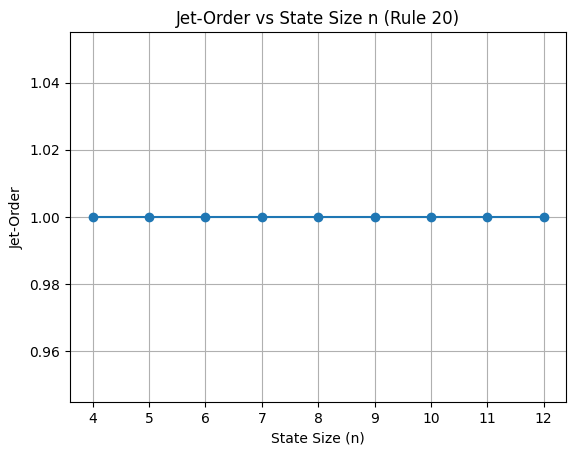

In [5]:
analyzer = JetOrderAnalyzer(rule_number=20)
analyzer.plot_jet_order_vs_n(n_values=[ r for r in range(4,13)], max_k=18)


Generated 16 states (expected 16)
Rule 30 | n=4: Jet-Order = 1
Generated 32 states (expected 32)
Rule 30 | n=5: Jet-Order = 1
Generated 64 states (expected 64)
Rule 30 | n=6: Jet-Order = 1
Generated 128 states (expected 128)
Rule 30 | n=7: Jet-Order = 1
Generated 256 states (expected 256)
Rule 30 | n=8: Jet-Order = 1
Generated 512 states (expected 512)
Rule 30 | n=9: Jet-Order = 1
Generated 1024 states (expected 1024)
Rule 30 | n=10: Jet-Order = 1
Generated 2048 states (expected 2048)
Rule 30 | n=11: Jet-Order = 1
Generated 4096 states (expected 4096)
Rule 30 | n=12: Jet-Order = 1


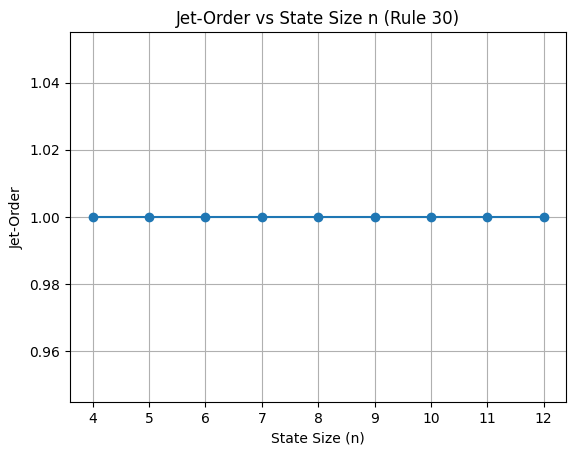

In [6]:
analyzer = JetOrderAnalyzer(rule_number=30)
analyzer.plot_jet_order_vs_n(n_values=[r for r in range(4,13)], max_k=18)

Generated 16 states (expected 16)
Rule 90 | n=4: Jet-Order = 1
Generated 32 states (expected 32)
Rule 90 | n=5: Jet-Order = 1
Generated 64 states (expected 64)
Rule 90 | n=6: Jet-Order = 1
Generated 128 states (expected 128)
Rule 90 | n=7: Jet-Order = 1
Generated 256 states (expected 256)
Rule 90 | n=8: Jet-Order = 1
Generated 512 states (expected 512)
Rule 90 | n=9: Jet-Order = 1
Generated 1024 states (expected 1024)
Rule 90 | n=10: Jet-Order = 1
Generated 2048 states (expected 2048)
Rule 90 | n=11: Jet-Order = 1
Generated 4096 states (expected 4096)
Rule 90 | n=12: Jet-Order = 1


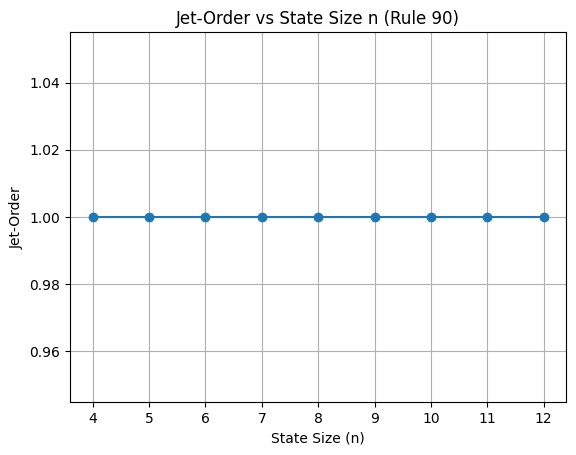

In [7]:
analyzer = JetOrderAnalyzer(rule_number=90)
analyzer.plot_jet_order_vs_n(n_values=[r for r in range(4, 13)], max_k=18)

Generated 16 states (expected 16)
Rule 110 | n=4: Jet-Order = 1
Generated 32 states (expected 32)
Rule 110 | n=5: Jet-Order = 1
Generated 64 states (expected 64)
Rule 110 | n=6: Jet-Order = 1
Generated 128 states (expected 128)
Rule 110 | n=7: Jet-Order = 1
Generated 256 states (expected 256)
Rule 110 | n=8: Jet-Order = 1
Generated 512 states (expected 512)
Rule 110 | n=9: Jet-Order = 1
Generated 1024 states (expected 1024)
Rule 110 | n=10: Jet-Order = 1
Generated 2048 states (expected 2048)
Rule 110 | n=11: Jet-Order = 1
Generated 4096 states (expected 4096)
Rule 110 | n=12: Jet-Order = 1


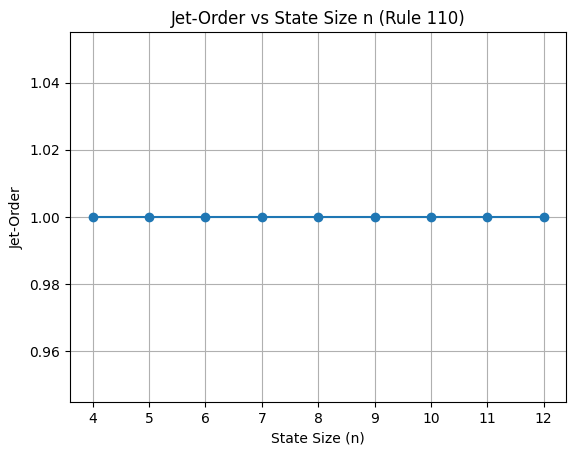

In [8]:
analyzer = JetOrderAnalyzer(rule_number=110)
analyzer.plot_jet_order_vs_n(n_values=[r for r in range(4,13)], max_k=18)

In [9]:
def compute_boolean_taylor_jet(self, x: cp.ndarray, k: int) -> cp.ndarray:
    """Compute jet following Boolean-Taylor-like expansion."""
    jet = [x]
    prev_state = x.copy()
    prev_diff = None

    for _ in range(k):
        next_state = self.eca_step(prev_state)
        diff = prev_state ^ next_state
        if prev_diff is not None:
            diff = diff ^ prev_diff  # Technique to isolate new behavior
        prev_diff = prev_state ^ next_state
        jet.append(diff)
        prev_state = next_state

    return cp.stack(jet)


In [10]:
def test_boolean_taylor_jet_order(analyzer, n, max_k=10):
    all_states = cp.array(list(itertools.product([0, 1], repeat=n)), dtype=cp.uint8)
    print(f"Testing Rule {analyzer.rule_number} | n={n} | total states: {len(all_states)}")

    for k in range(1, max_k + 1):
        signatures = {}
        collision_found = False
        for x in all_states:
            jet = analyzer.compute_boolean_taylor_jet(x, k)
            jet_flat = tuple(jet.flatten().get().tolist())
            fx = analyzer.eca_step(x)
            fx_tuple = tuple(fx.get().tolist())
            if jet_flat in signatures:
                if signatures[jet_flat] != fx_tuple:
                    collision_found = True
                    break
            else:
                signatures[jet_flat] = fx_tuple
        if not collision_found:
            print(f"Jet-Order = {k} is sufficient")
            return k
    print("No sufficient jet order found within max_k")
    return None

# Example usage:
analyzer = JetOrderAnalyzer(rule_number=110)
test_boolean_taylor_jet_order(analyzer, n=12, max_k=24)


Testing Rule 110 | n=12 | total states: 4096
Jet-Order = 1 is sufficient


1

In [11]:
import matplotlib.pyplot as plt

def visualize_boolean_jet(analyzer, n: int, k: int, x0: cp.ndarray = None):
    """
    Visualize the Boolean Jet Space of a rule from a starting state x0.
    """
    if x0 is None:
        x0 = cp.random.randint(0, 2, size=n, dtype=cp.uint8)

    jet = analyzer.compute_boolean_taylor_jet(x0, k).get()

    plt.figure(figsize=(12, k * 0.4))
    plt.imshow(jet, cmap='binary', aspect='auto')
    plt.title(f"Boolean Jet Expansion for Rule {analyzer.rule_number}, n={n}, k={k}")
    plt.xlabel("Cell Index")
    plt.ylabel("Derivative Order")
    plt.colorbar(label='Bit Value')
    plt.show()

    print(f"Initial state x0: {''.join(map(str, x0.get().tolist()))}")


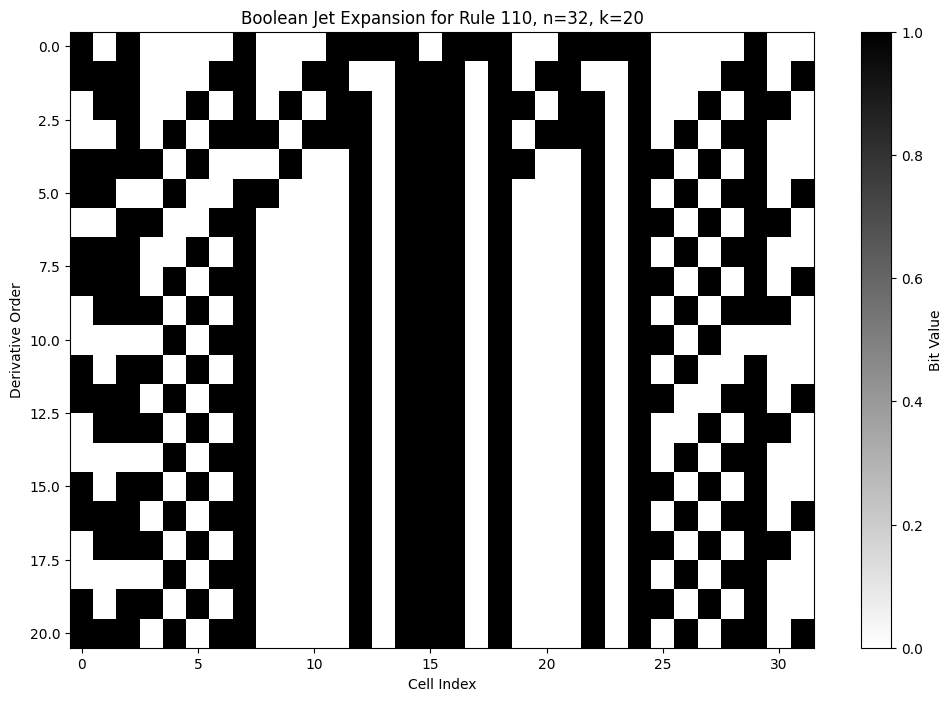

Initial state x0: 10100001000111101110011110000100


In [12]:
analyzer = JetOrderAnalyzer(rule_number=110)
visualize_boolean_jet(analyzer, n=32, k=20)

In [13]:
def compare_jet_methods(analyzer, n: int, k: int, x0: cp.ndarray = None):
    """
    Compare XOR-based jet and Boolean Taylor jet for a given initial condition.
    """
    if x0 is None:
        x0 = cp.random.randint(0, 2, size=n, dtype=cp.uint8)

    xor_jet = analyzer.compute_xor_jet(x0, k).get()
    taylor_jet = analyzer.compute_boolean_taylor_jet(x0, k).get()

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    axes[0].imshow(xor_jet, cmap='binary', aspect='auto')
    axes[0].set_title(f"XOR Jet - Rule {analyzer.rule_number}, n={n}, k={k}")
    axes[0].set_ylabel("Derivative Order")

    axes[1].imshow(taylor_jet, cmap='binary', aspect='auto')
    axes[1].set_title(f"Boolean Taylor Jet - Rule {analyzer.rule_number}, n={n}, k={k}")
    axes[1].set_xlabel("Cell Index")
    axes[1].set_ylabel("Derivative Order")

    plt.tight_layout()
    plt.show()

    print(f"Initial state x0: {''.join(map(str, x0.get().tolist()))}")


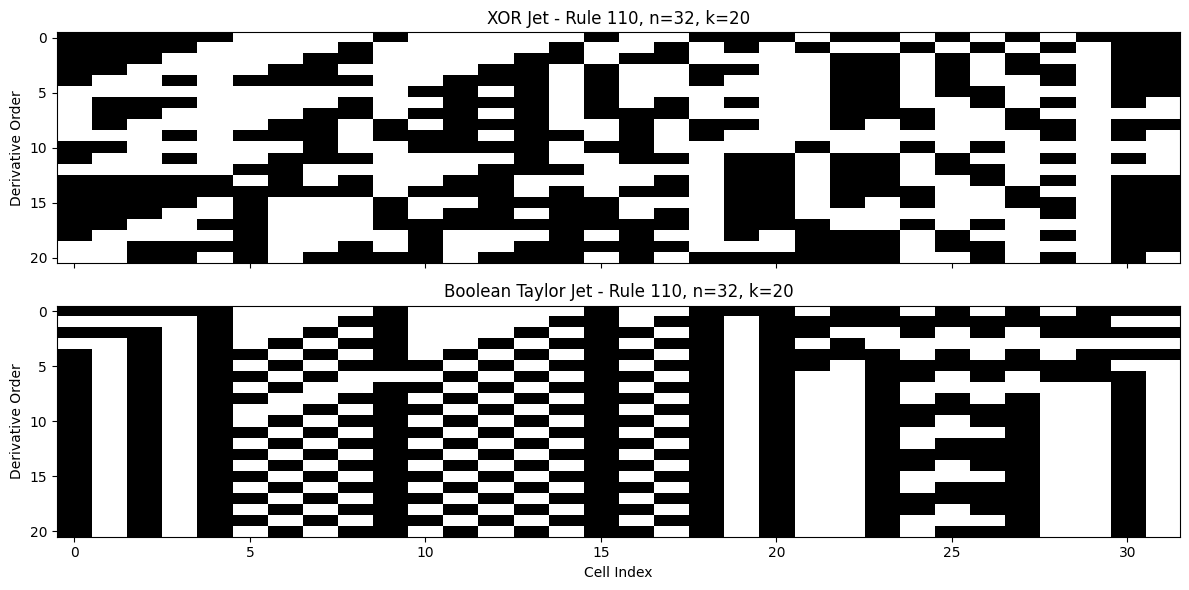

Initial state x0: 11111000010000010011101101010111


In [14]:
analyzer = JetOrderAnalyzer(rule_number=110)
compare_jet_methods(analyzer, n=32, k=20)


In [20]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

class JetOrderAnalyzer:
    def __init__(self, rule_number: int):
        self.rule_number = rule_number
        self.rule_bits = cp.array([(rule_number >> i) & 1 for i in range(8)], dtype=cp.uint8)

    def eca_step(self, x: cp.ndarray) -> cp.ndarray:
        left = cp.roll(x, 1)
        center = x
        right = cp.roll(x, -1)
        patterns = (left << 2) | (center << 1) | right
        return self.rule_bits[patterns]

    def compute_xor_jet(self, x0: cp.ndarray, k: int) -> cp.ndarray:
        """
        XOR Jet: J^k(x) = [x, x ⊕ f(x), x ⊕ f²(x), ..., x ⊕ f^k(x)]
        """
        jet = cp.zeros((k + 1, len(x0)), dtype=cp.uint8)
        jet[0] = x0
        current = x0.copy()
        for j in range(1, k + 1):
            current = self.eca_step(current)
            jet[j] = x0 ^ current
        return jet

    def compute_boolean_taylor_jet(self, x0: cp.ndarray, k: int) -> cp.ndarray:
        """
        Boolean Taylor Jet: J^k(x) = [x, d¹f(x), d²f(x), ..., d^k f(x)]
        where d^j f(x) = f^j(x) ⊕ f^{j-1}(x)
        """
        jet = cp.zeros((k + 1, len(x0)), dtype=cp.uint8)
        jet[0] = x0
        prev = x0.copy()
        for j in range(1, k + 1):
            fx = self.eca_step(prev)
            jet[j] = prev ^ fx
            prev = fx
        return jet

    def compute_taylor_polynomial_order(self, x0: cp.ndarray, max_k: int = 50) -> int:
        """
        Compute minimal k such that the Boolean Taylor jet begins to repeat,
        treating each row (d^j f(x)) as a state and looking for recurrence.
        """
        jet_rows = []
        prev = x0.copy()

        for k in range(1, max_k + 1):
            fx = self.eca_step(prev)
            diff = prev ^ fx
            diff_key = tuple(diff.get().tolist())

            if diff_key in jet_rows:
                return k - 1  # Jet has cycled
            jet_rows.append(diff_key)
            prev = fx

        return None


        return None  # No repetition up to max_k

    def visualize_jet(self, jet: np.ndarray, title: str):
        plt.figure(figsize=(12, 4))
        plt.imshow(jet, cmap='gray', aspect='auto', interpolation='nearest')
        plt.title(title)
        plt.xlabel("Cell Index")
        plt.ylabel("Jet Row (Derivative Order)")
        plt.colorbar(label='Bit')
        plt.show()

    def compare_jets(self, x0: cp.ndarray, k: int):
        xor_jet = self.compute_xor_jet(x0, k).get()
        taylor_jet = self.compute_boolean_taylor_jet(x0, k).get()
        diff = np.bitwise_xor(xor_jet, taylor_jet)

        self.visualize_jet(xor_jet, f"XOR Jet - Rule {self.rule_number}, k={k}")
        self.visualize_jet(taylor_jet, f"Boolean Taylor Jet - Rule {self.rule_number}, k={k}")
        self.visualize_jet(diff, f"Difference (XOR ⊕ Taylor) - Rule {self.rule_number}, k={k}")


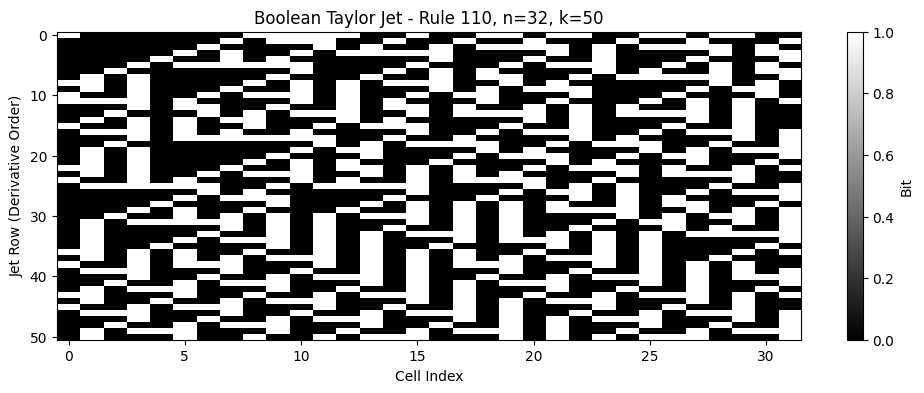

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 1]], dtype=uint8)
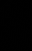

In [22]:
# Parameters
rule = 110
n = 32
k = 50

# Generate random initial state
cp.random.seed(42)
x0 = cp.random.randint(0, 2, size=n, dtype=cp.uint8)

# Initialize analyzer
analyzer = JetOrderAnalyzer(rule)

# Compute Boolean Taylor Jet
taylor_jet = analyzer.compute_boolean_taylor_jet(x0, k).get()

# Visualize
analyzer.visualize_jet(taylor_jet, f"Boolean Taylor Jet - Rule {rule}, n={n}, k={k}")

# Optional: return the jet for external inspection
taylor_jet


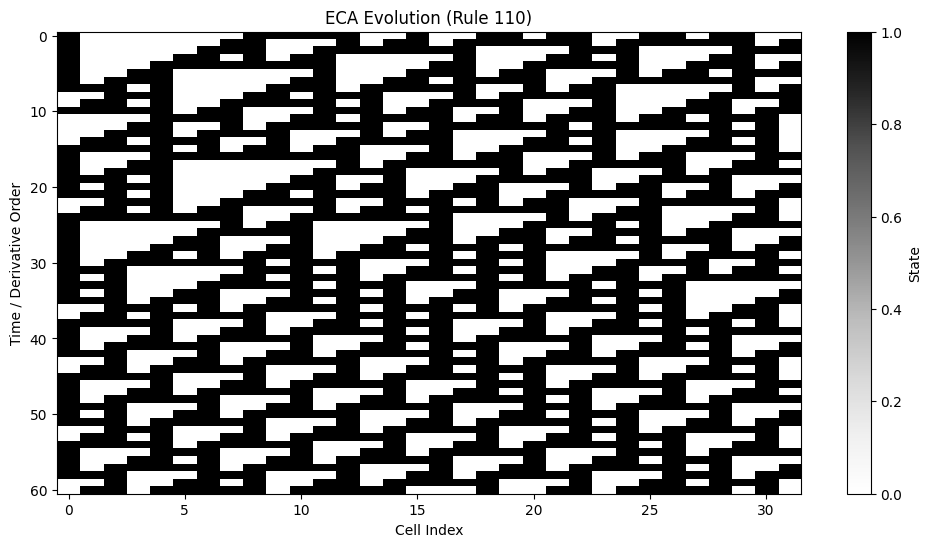

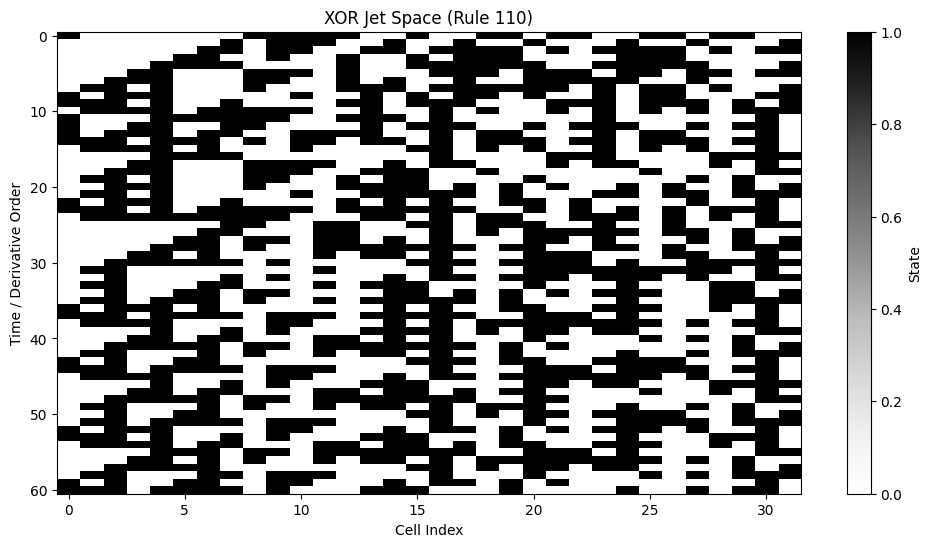

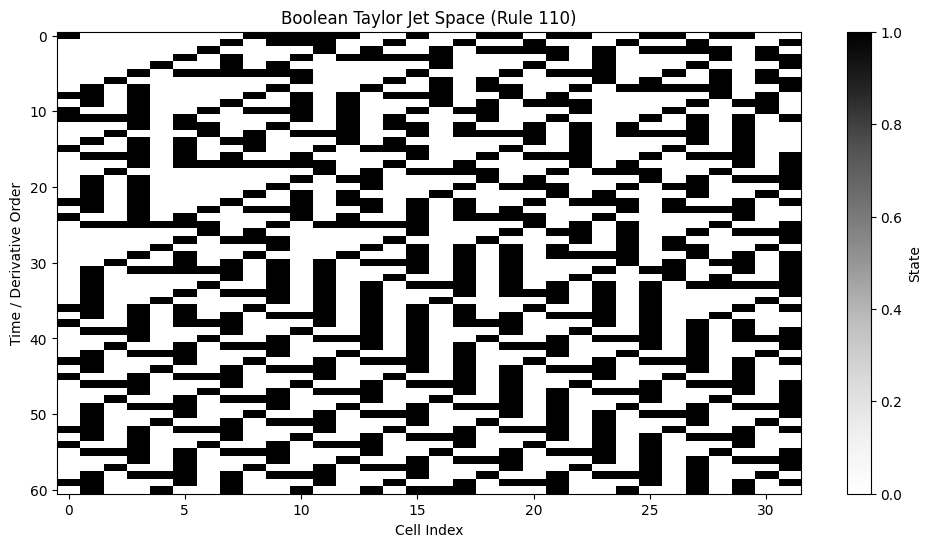

In [25]:
# Parameters
rule = 110
n = 32
k = 60

# Generate initial condition
cp.random.seed(42)
x0 = cp.random.randint(0, 2, size=n, dtype=cp.uint8)

# Initialize analyzer
analyzer = JetOrderAnalyzer(rule)

# Compute normal ECA evolution
def compute_eca_evolution(analyzer, x0, steps):
    trajectory = cp.zeros((steps + 1, n), dtype=cp.uint8)
    trajectory[0] = x0
    x = x0.copy()
    for t in range(1, steps + 1):
        x = analyzer.eca_step(x)
        trajectory[t] = x
    return trajectory.get()

trajectory = compute_eca_evolution(analyzer, x0, k)
xor_jet = analyzer.compute_xor_jet(x0, k).get()
taylor_jet = analyzer.compute_boolean_taylor_jet(x0, k).get()

# Visualization function
def visualize_matrix(matrix, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(matrix, cmap="Greys", interpolation="nearest", aspect="auto")
    plt.title(title)
    plt.xlabel("Cell Index")
    plt.ylabel("Time / Derivative Order")
    plt.colorbar(label="State")
    plt.show()

# Show all three
visualize_matrix(trajectory, f"ECA Evolution (Rule {rule})")
visualize_matrix(xor_jet, f"XOR Jet Space (Rule {rule})")
visualize_matrix(taylor_jet, f"Boolean Taylor Jet Space (Rule {rule})")


In [26]:
def detect_eca_cycle(analyzer, x0: cp.ndarray, max_steps=1000) -> tuple:
    seen = {}
    state = x0.copy()
    trajectory = [state.get()]

    for t in range(1, max_steps + 1):
        state = analyzer.eca_step(state)
        state_key = tuple(state.get().tolist())

        if state_key in seen:
            cycle_start = seen[state_key]
            cycle_length = t - cycle_start
            return trajectory, cycle_start, cycle_length

        seen[state_key] = t
        trajectory.append(state.get())

    return trajectory, None, None  # No cycle found


In [27]:
def visualize_all_views(analyzer, trajectory, cycle_start=None, cycle_length=None):
    k = len(trajectory) - 1
    n = len(trajectory[0])
    traj_matrix = np.array(trajectory, dtype=np.uint8)

    x0 = cp.array(trajectory[0], dtype=cp.uint8)
    xor_jet = analyzer.compute_xor_jet(x0, k).get()
    taylor_jet = analyzer.compute_boolean_taylor_jet(x0, k).get()

    def viz(matrix, title):
        plt.figure(figsize=(12, 6))
        plt.imshow(matrix, cmap="Greys", interpolation="nearest", aspect="auto")
        if cycle_start is not None and cycle_length is not None:
            plt.axhline(cycle_start, color='red', linestyle='--', label='Cycle Start')
            plt.axhline(cycle_start + cycle_length, color='green', linestyle='--', label='Cycle End')
            plt.legend()
        plt.title(title)
        plt.xlabel("Cell Index")
        plt.ylabel("Time / Derivative Order")
        plt.colorbar(label="State")
        plt.show()

    viz(traj_matrix, f"ECA Evolution (Rule {analyzer.rule_number})")
    viz(xor_jet, f"XOR Jet Space (Rule {analyzer.rule_number})")
    viz(taylor_jet, f"Boolean Taylor Jet Space (Rule {analyzer.rule_number})")


Cycle detected at step 39 with length 48


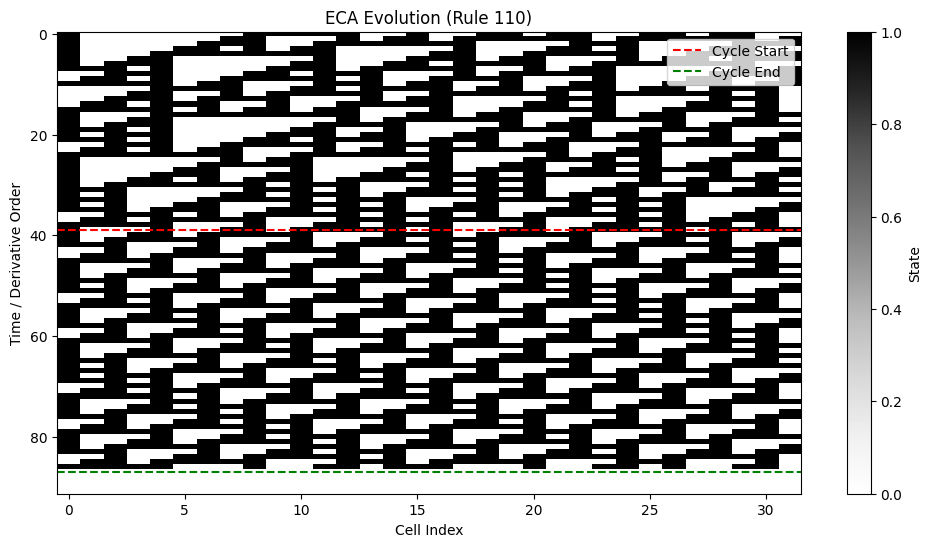

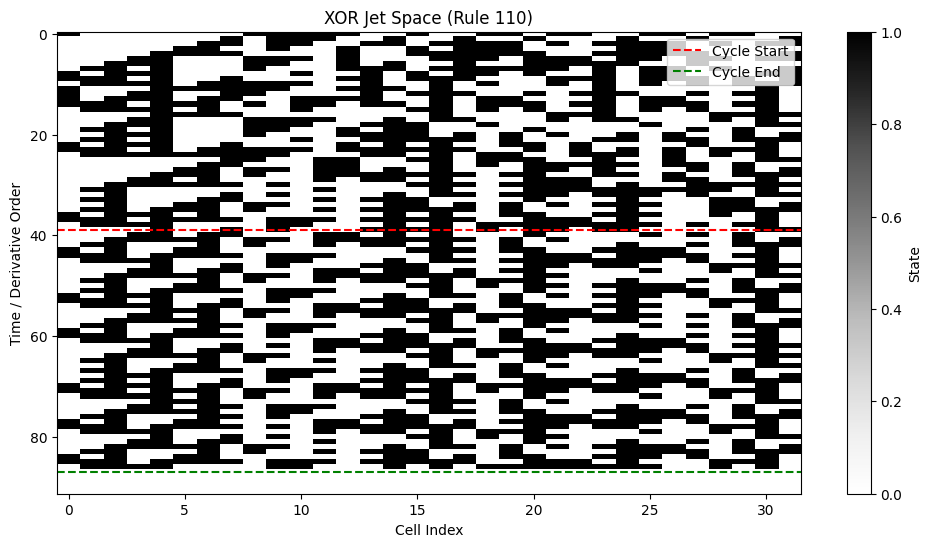

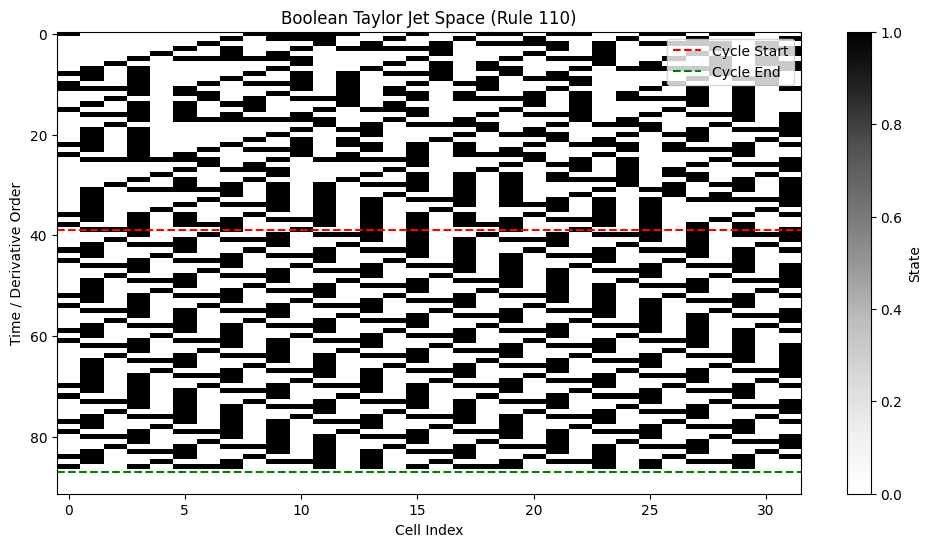

In [28]:
rule = 110
n = 32
cp.random.seed(42)
x0 = cp.random.randint(0, 2, size=n, dtype=cp.uint8)

analyzer = JetOrderAnalyzer(rule)

trajectory, cycle_start, cycle_length = detect_eca_cycle(analyzer, x0, max_steps=1000)
print(f"Cycle detected at step {cycle_start} with length {cycle_length}" if cycle_start else "No cycle detected.")

visualize_all_views(analyzer, trajectory, cycle_start, cycle_length)


In [29]:
def get_canonical_cycle_state(trajectory, cycle_start, cycle_length):
    cycle_states = trajectory[cycle_start:cycle_start + cycle_length]
    # Convert to binary strings for lexicographic comparison
    binary_strs = [''.join(map(str, row)) for row in cycle_states]
    lex_min_index = binary_strs.index(min(binary_strs))
    return cp.array(cycle_states[lex_min_index], dtype=cp.uint8)


In [30]:
def visualize_from_cycle_state(analyzer, x0: cp.ndarray, k: int = 100):
    traj = [x0.get()]
    current = x0.copy()
    for _ in range(k):
        current = analyzer.eca_step(current)
        traj.append(current.get())

    xor_jet = analyzer.compute_xor_jet(x0, k).get()
    taylor_jet = analyzer.compute_boolean_taylor_jet(x0, k).get()

    def viz(matrix, title):
        plt.figure(figsize=(12, 6))
        plt.imshow(matrix, cmap="Greys", interpolation="nearest", aspect="auto")
        plt.title(title)
        plt.xlabel("Cell Index")
        plt.ylabel("Time / Derivative Order")
        plt.colorbar(label="State")
        plt.show()

    viz(np.array(traj, dtype=np.uint8), "ECA Evolution from Canonical Cycle State")
    viz(xor_jet, "XOR Jet from Canonical Cycle State")
    viz(taylor_jet, "Taylor Jet from Canonical Cycle State")


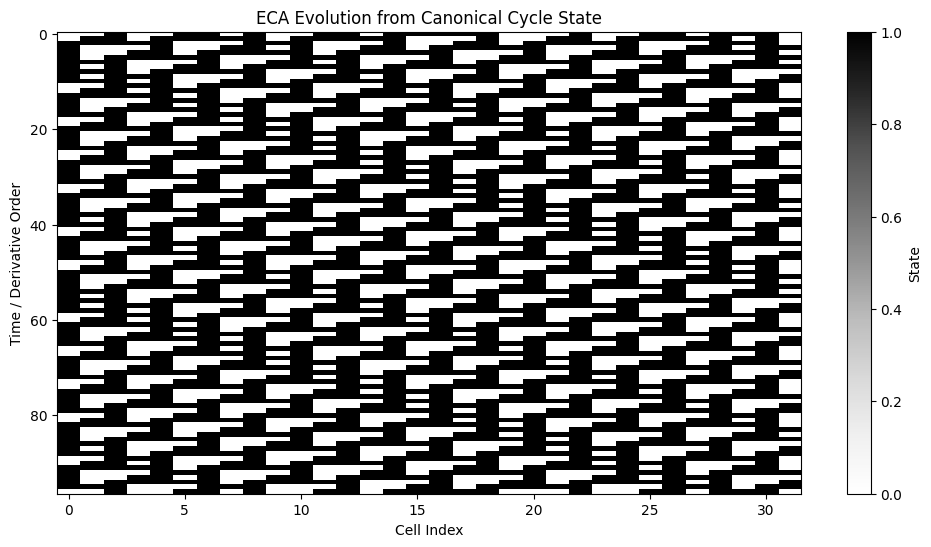

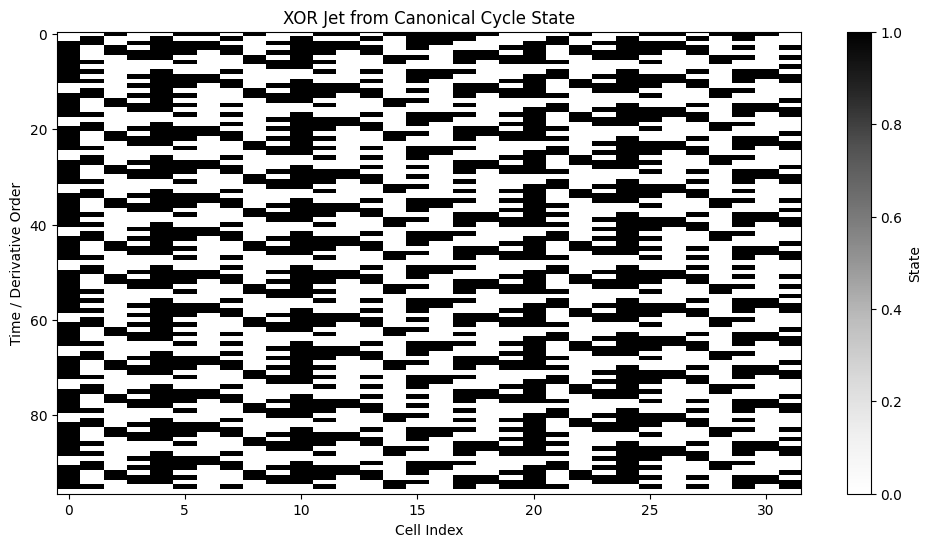

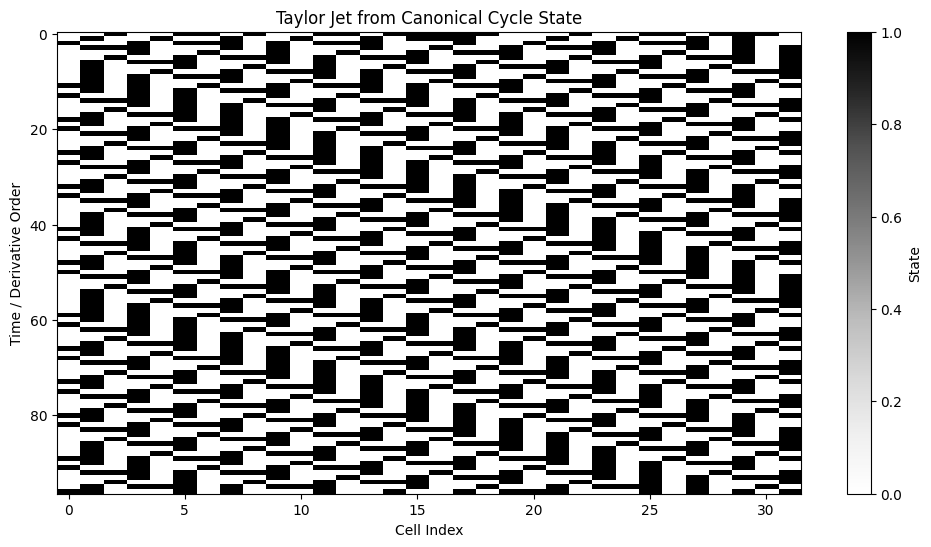

In [31]:
# Detect cycle
trajectory, cycle_start, cycle_length = detect_eca_cycle(analyzer, x0, max_steps=1000)

# Get lex minimal state from cycle
x_cycle = get_canonical_cycle_state(trajectory, cycle_start, cycle_length)

# Visualize from canonical state
visualize_from_cycle_state(analyzer, x_cycle, k=cycle_length * 2)


No cycle detected.


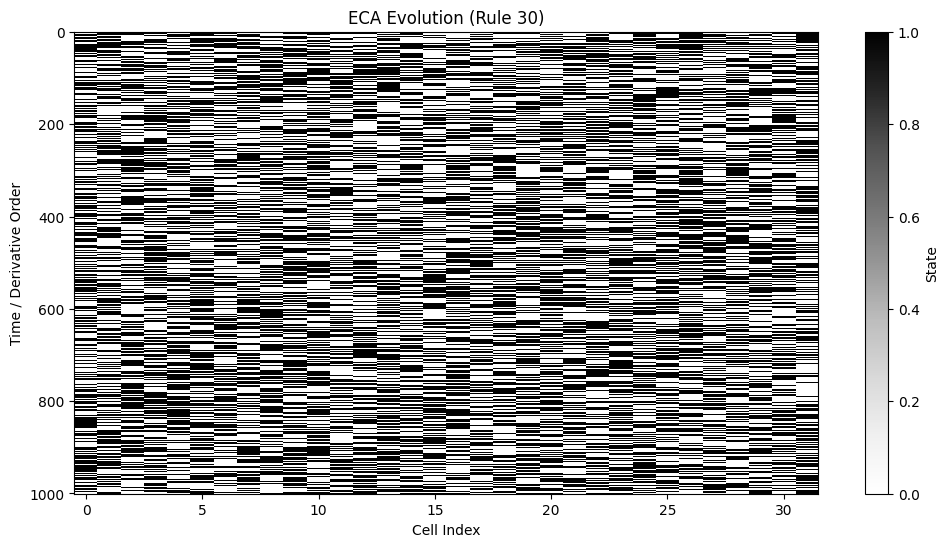

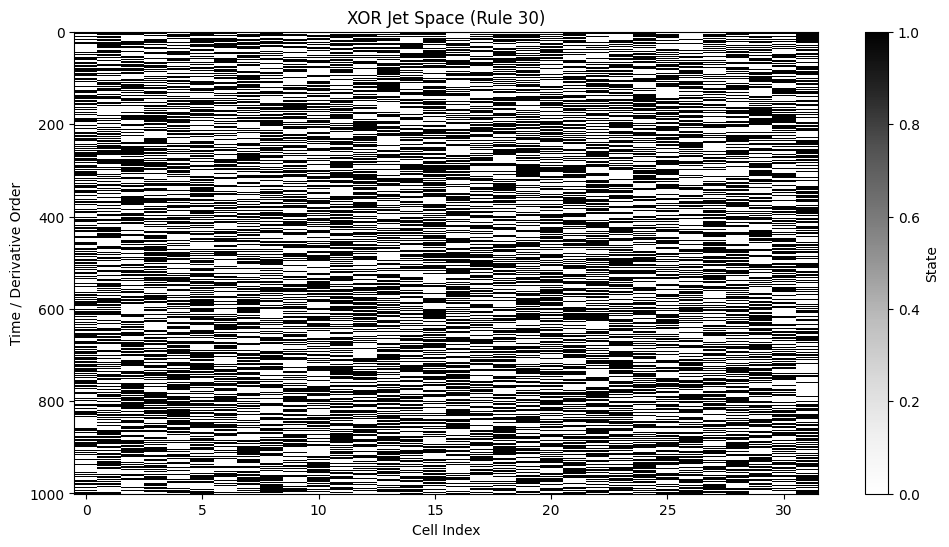

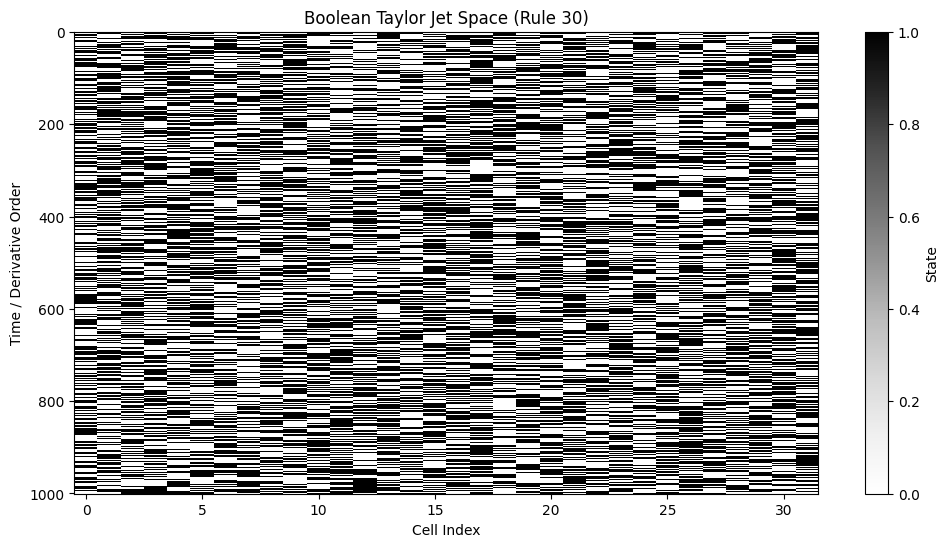

In [34]:
rule = 30
n = 32
cp.random.seed(42)
x0 = cp.random.randint(0, 2, size=n, dtype=cp.uint8)

analyzer = JetOrderAnalyzer(rule)

trajectory, cycle_start, cycle_length = detect_eca_cycle(analyzer, x0, max_steps=1000)
print(f"Cycle detected at step {cycle_start} with length {cycle_length}" if cycle_start else "No cycle detected.")

visualize_all_views(analyzer, trajectory, cycle_start, cycle_length)

Cycle detected at step 1 with length 12


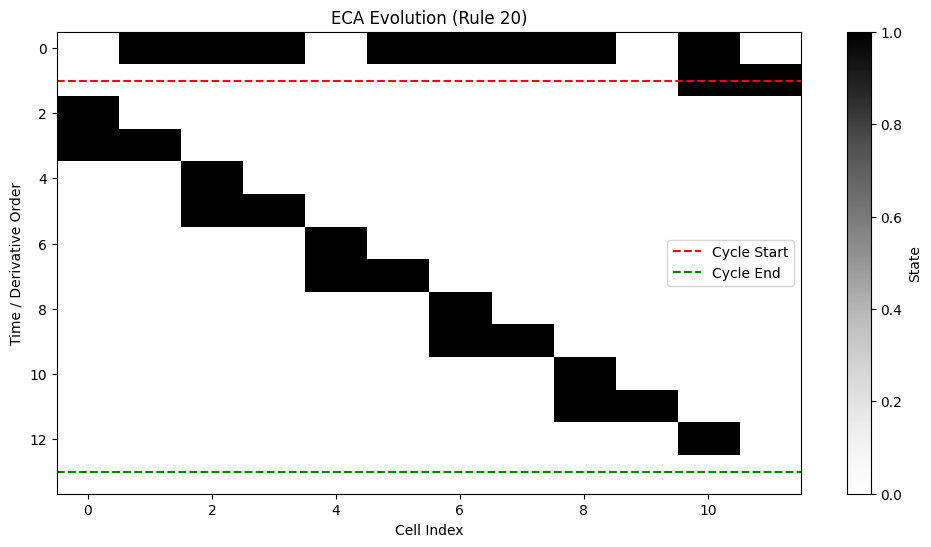

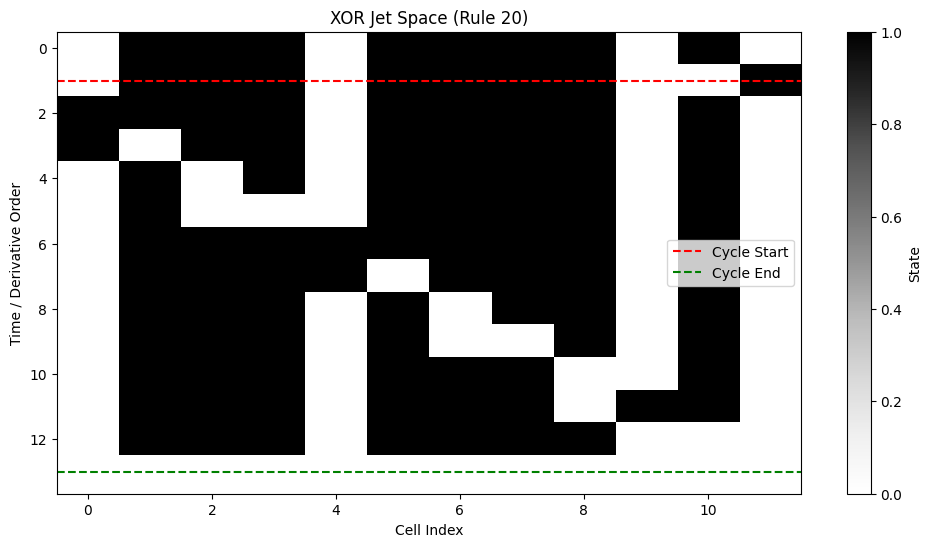

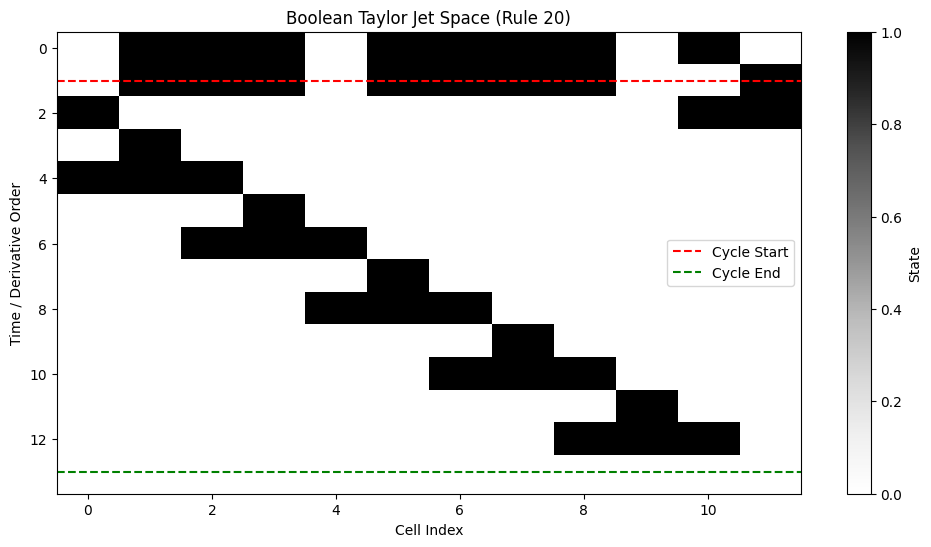

In [40]:
rule = 20
n = 12
cp.random.seed(3)
x0 = cp.random.randint(0, 2, size=n, dtype=cp.uint8)

analyzer = JetOrderAnalyzer(rule)

trajectory, cycle_start, cycle_length = detect_eca_cycle(analyzer, x0, max_steps=1000)
print(f"Cycle detected at step {cycle_start} with length {cycle_length}" if cycle_start else "No cycle detected.")

visualize_all_views(analyzer, trajectory, cycle_start, cycle_length)